## Operational Metrics

While accuracy metrics give us a sense of decision correctness, we need to calculate metrics that reflect the priorities of the business case. For that purpose, we look at three metrics here

1. dollars per second -- For a set of decisions , looks at how much money was made for the merchant normalized by time spent on the decisions. 
2. average decision time -- Measure how fast the analysts were in making the decisions. Dollar value is not considered
3. percent dollar regret -- For a set of decisions, calculates how far the decisions were from the perfect case. The time is not considered


### Handling Suspicious

For decisions marked as 'suspicious', we use four strategies to understand the bounds of the metrics

1. Assume that the suspicious elavates the decision to a higher level analyst, and they get it right. We assume the decision is correct, and add a time penalty for the review process ---> This is the one we chose
2. Assume that those records are all declined (no decision time penalty)
3. Assume that those records are all approved (no decision time penalty)
4. Ignore the decisions from calculation (least desirable option)


In [2]:
import os
import sys
sys.path.append('../../')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample

In [4]:
# from ducktales.feedzai_experiments.exp_results_analysis import fetch_all_decisions, grp_names_disp_name
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics, assign_conf_mat_cell, _modify_value_and_time, assign_conf_mat_cell,
    chi_square_test
)

In [5]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

In [6]:
def plot_metrics_feedzai_style(metrics_dict, title='', confidence=0.9, legend=True):
    groups = list(metrics_dict.keys())
    x_pos = np.arange(len(groups))
    interval = stats.norm.ppf(1-(1-confidence)/2)
    means = [x['mean'] for _, x in metrics_dict.items()]
    errors = [x['se'] * interval for _, x in metrics_dict.items()]
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 4))
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
    
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])

    for j, grp in enumerate(pdr.keys()):
        a, caps, b = ax1.errorbar(
            means[j], (j), xerr=errors[j], ls='',
            elinewidth=2, capsize=10, color=colors[j]
        )

        ax1.scatter(means[j], (j), color=colors[j], marker='o')

        for cap in caps:
                cap.set_markeredgewidth(2)

        ax1.set_title(title, fontsize=11)
        ax1.yaxis.grid(False)
        ax1.xaxis.grid()

        ax1.set_yticks([])
        ax1.set_ylim(len(groups),-1)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)

    if legend:
        color_part = []
        for i in range(len(pdr.keys())):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, pdr.keys()

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(groups),
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)

In [7]:
def plot_metrics(metrics, title='', tick_order=['Control-A', 'Control-B', 'TreeSHAP', 'TreeInterpreter', 'LIME'], confidence=0.9):
    """ Dollars made, per second"""
    # n = x
    # h = se * stats.t.ppf((1 + confidence) / 2., n-1)
#     fig, ax = plt.subplots(dpi=200)
    fig, ax = plt.subplots()
    ax.barh(
        np.arange(4, -1, -1), 
        [x['mean'] for _, x in metrics.iterrows()], 
        xerr=[x['se'] * stats.norm.ppf(1 - (1 - confidence) / 2) for _, x in metrics.iterrows()], #CI
        align='center', 
        alpha=0.7,  
        capsize=5,
        color=colors
    )
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(tick_order[::-1])
    ax.set_title(title)
    sns.despine()
    ax.spines['left'].set_visible(False)

In [8]:
def plot_metrics2(metrics, plot_order, colors, title='', confidence=0.9, legend=True, xlim=None):
    interval = stats.norm.ppf(1-(1-confidence)/2)
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 3), dpi=200)
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
        
    for i, group in enumerate(plot_order):
        msk = metrics['group'] == group
        row = metrics[msk].iloc[0, :]
        a, caps, b = ax1.errorbar(
            row['mean'], (i), xerr=row['se'] * interval, ls='',
            elinewidth=2, capsize=5, color=colors[i]
        )
        
        ax1.scatter(row['mean'], (i), color=colors[i], marker='o')
        for cap in caps:
            cap.set_markeredgewidth(2)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)
        ax1.set_yticks([])
    
    ax1.xaxis.grid()
    ax1.set_title(title)
    if xlim is not None:
        ax1.set_xlim(xlim)
        
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])
        color_part = []
        for i in range(len(metrics)):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, plot_order

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(metrics) - 2,
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)
            
def plot_power_curves(metrics, pvals, sample_sizes_list):
    fig, ax = plt.subplots(figsize=(6, 4))

    for comp in pvals.keys():
        es = _effect_size_diff(
            metrics[comp[0]]['mean'],
            metrics[comp[1]]['mean'],
            metrics[comp[0]]['var'],
            metrics[comp[1]]['var']
        )

        powers = list()

        for sample_size in sample_sizes_list:
            power = tt_ind_solve_power(effect_size=es, nobs1=metrics[comp[0]]['n'], alpha=0.1, ratio=(sample_size/metrics[comp[0]]['n']), power=None)
            powers.append(power)

        plt.plot(sample_sizes_list, powers, label=', '.join(comp), marker='.')

    plt.axvline(x=500, color='k', linestyle=':', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.01, 1))
    ax.set_ylabel('power')
    ax.set_xlabel('sample size')

    sns.despine()

    return ax, fig


In [9]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Fetch decisions

In [10]:
all_decisions = get_all_decisions(engine, schemas, users, groups)

In [11]:
all_decisions['group'].unique()

array(['ML Model', 'Irrelevant', 'Data', 'Random', 'LIME', 'TreeInt',
       'TreeSHAP'], dtype=object)

In [12]:
suspicious_msk = all_decisions['decision'] == 'suspicious'

### Adjusting the transaction values

There are a few transactions (mainly in the control arms) that are very high valued compared to the rest. These can skew the metrics when we incoroporate the transaction values. So, we are capping the transaction values at $2000.  

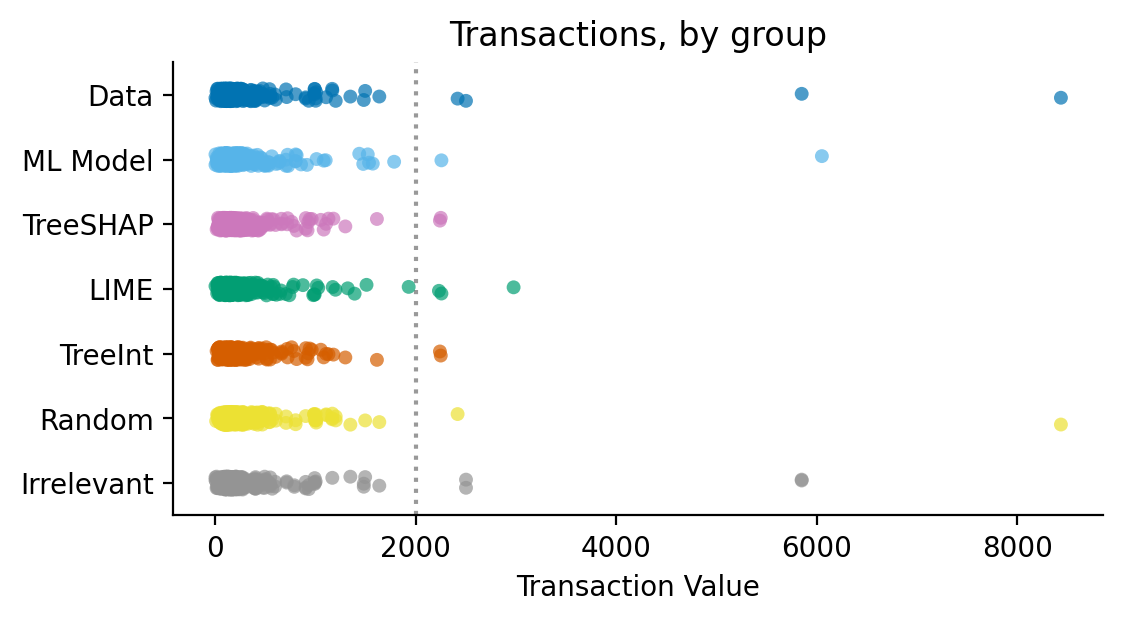

In [13]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=200)
sns.stripplot(
    x="trx_amnt", y="group", 
    data=all_decisions, alpha=0.7, 
    palette=colors, order=group_order)
plt.axvline(x=2000, color='k', linestyle=':', alpha=0.4)
sns.despine()
t = plt.title('Transactions, by group')
axes.set_xlabel('Transaction Value')
t = axes.set_ylabel('')

In [14]:
# transaction_value_cap = 500
transaction_value_cap = 2000

In [15]:
msk = all_decisions['trx_amnt'] > transaction_value_cap
all_decisions.loc[msk, 'trx_amnt'] = transaction_value_cap

In [16]:
comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'LIME'),
    ('Control-B', 'TreeInt'),
    ('Control-B', 'TreeSHAP'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
]

In [16]:
def print_significant_tests(ttest_res, alpha=0.1):
#     nothing_significant = True
#     for k, v in ttest_res.items():
#         if v['pval'] <= alpha:
#             nothing_significant = False
#             print(k, v)
            
#     if nothing_significant:
#         print('No statistically significant differences found!')
    msk = ttest_res['p-val'] <= alpha
    print(ttest_res[msk])
    
    if ttest_res[msk].empty:
        print('No statistically significant differences found!')

In [110]:
def ttests_operational_metrics(metrics, comparisons, group_col='group'):
    
    results = list()

    for comp in comparisons:
        mean1 = metrics[metrics[group_col] == comp[0]]['mean'].iloc[0]
        mean2 = metrics[metrics[group_col] == comp[1]]['mean'].iloc[0]
        
        var1 = metrics[metrics[group_col] == comp[0]]['var'].iloc[0]
        var2 = metrics[metrics[group_col] == comp[1]]['var'].iloc[0]

        n1 = metrics[metrics[group_col] == comp[0]]['n'].iloc[0]
        n2 = metrics[metrics[group_col] == comp[1]]['n'].iloc[0]
        
        res = stats.ttest_ind_from_stats(
            mean1, np.sqrt(var1), n1,
            mean2, np.sqrt(var2), n2,
        )
        
        
        d = dict()
        d['comparison'] = comp
        d['t-stat'] = res.statistic
        d['p-val'] = res.pvalue
        
        results.append(d)
        
    return pd.DataFrame(results)

#### Dollars made per Second

Correct
               comparison     p-val    t-stat
0  (Control-A, Control-B)  0.009411 -2.601834
3   (Control-B, TreeSHAP)  0.084323  1.727865
6       (TreeInt, Random)  0.058330 -1.895407
7      (TreeSHAP, Random)  0.041883 -2.037327
Approve
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.023824  2.263442
3    (Control-B, TreeSHAP)  0.038392  2.073402
5  (Control-B, Irrelevant)  0.003441  2.932311
Decline
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.016482  2.402138
3    (Control-B, TreeSHAP)  0.025487  2.237309
5  (Control-B, Irrelevant)  0.001409  3.201821
Ignore
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.025013  2.244699
3    (Control-B, TreeSHAP)  0.027070  2.213873
5  (Control-B, Irrelevant)  0.001597  3.165241


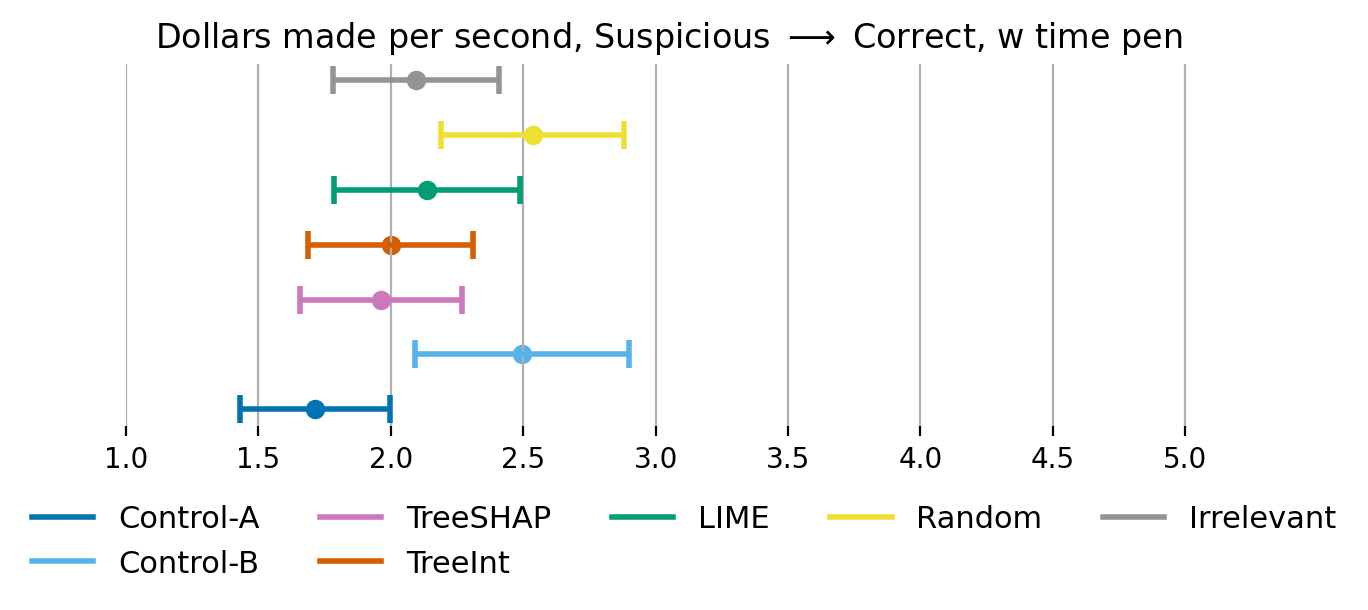

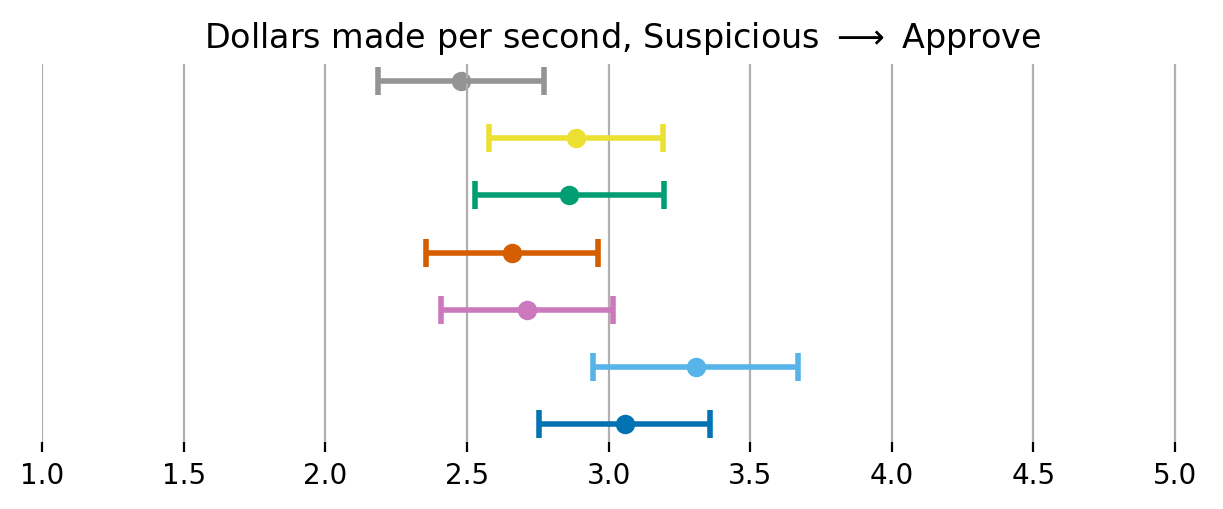

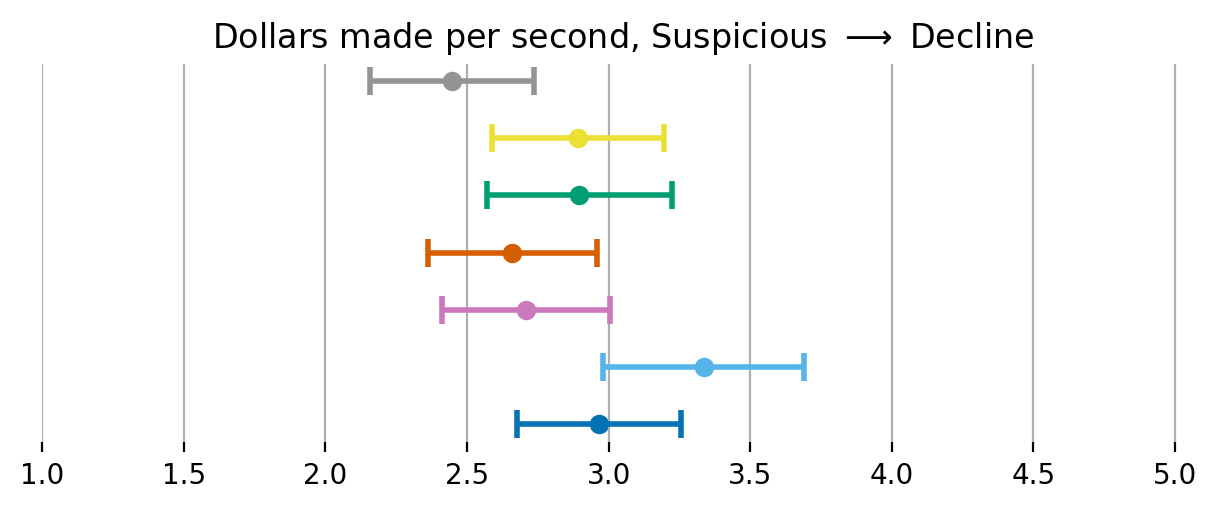

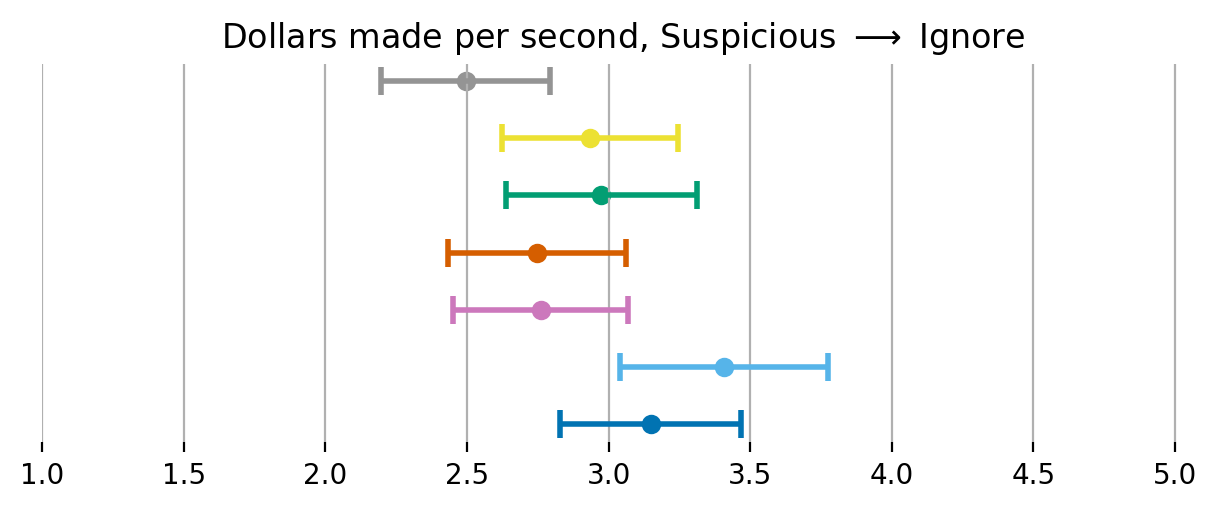

In [91]:
df = dps(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, 
              title='Dollars made per second, Suspicious $\longrightarrow$ Correct, w time pen', 
              xlim=[1, 5.1], legend=True
             )
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)


df = dps(all_decisions, params, 'approve', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Approve', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Approve')
print_significant_tests(ttests)



df = dps(all_decisions, params, 'decline', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Decline', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Decline')
print_significant_tests(ttests)

df = dps(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Ignore', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Ignore')
print_significant_tests(ttests)


#### Average Decision Time

Correct
                comparison     p-val    t-stat
0   (Control-A, Control-B)  0.000673  3.410986
2     (Control-B, TreeInt)  0.035436 -2.106218
3    (Control-B, TreeSHAP)  0.019479 -2.340039
5  (Control-B, Irrelevant)  0.084292 -1.728035
7       (Random, TreeSHAP)  0.089735 -1.698462


/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


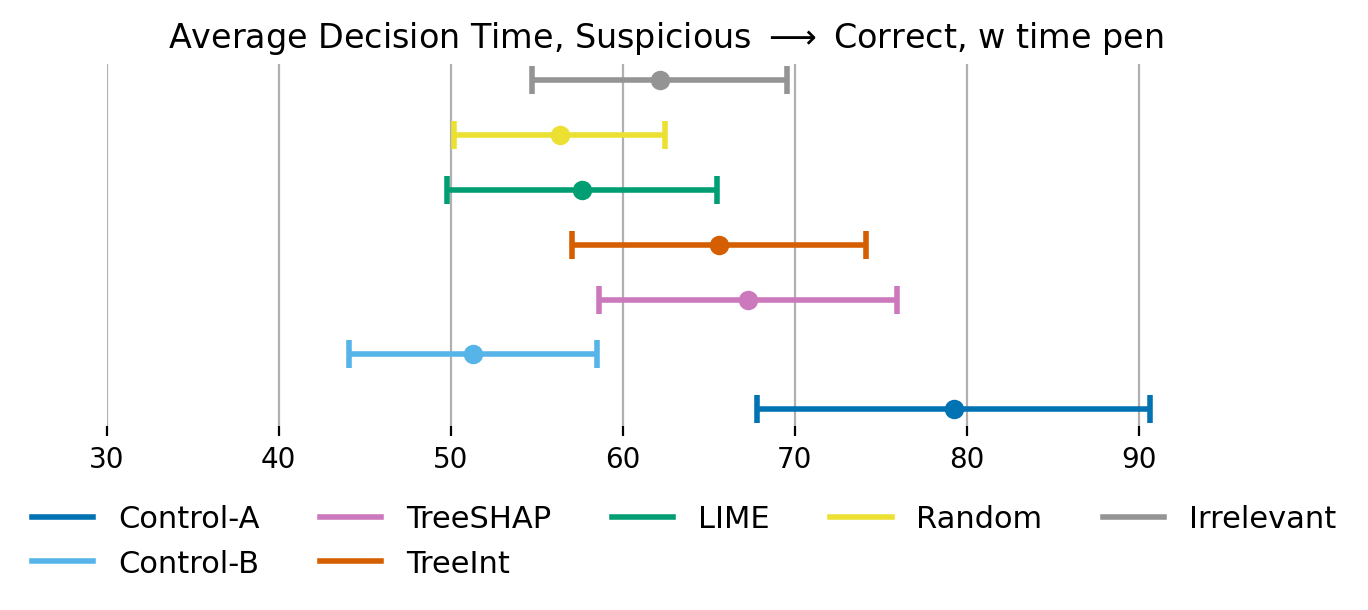

In [32]:
df = dt(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Correct, w time pen', xlim=[30, 95])
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)

# df = dt(all_decisions, params, 'approve', ['group'])
# plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Approve', xlim=[30, 95])
# ttests = ttests_operational_metrics(df, comparisons)
# print('approve')
# print_significant_tests(ttests)


# df = dt(all_decisions, params, 'decline', ['group'])
# plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Decline', xlim=[30, 95])
# ttests = ttests_operational_metrics(df, comparisons)
# print('decline')
# print_significant_tests(ttests)


# df = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
# plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Ignore', xlim=[30, 95])
# ttests = ttests_operational_metrics(df, comparisons)
# print('ignore')
# print_significant_tests(ttests)



In [33]:
ttests

comparison     p-val    t-stat
0    (Control-A, Control-B)  0.000673  3.410986
1         (Control-B, LIME)  0.325846 -0.983000
2      (Control-B, TreeInt)  0.035436 -2.106218
3     (Control-B, TreeSHAP)  0.019479 -2.340039
4       (Control-B, Random)  0.380179 -0.877957
5   (Control-B, Irrelevant)  0.084292 -1.728035
6         (Random, TreeInt)  0.148234 -1.446927
7        (Random, TreeSHAP)  0.089735 -1.698462
8            (Random, LIME)  0.828074 -0.217229
9     (Irrelevant, TreeInt)  0.617419 -0.499669
10   (Irrelevant, TreeSHAP)  0.459225 -0.740411
11       (Irrelevant, LIME)  0.493572  0.684892
12     (Irrelevant, Random)  0.321031  0.992837
13         (LIME, TreeSHAP)  0.175191 -1.356679
14          (LIME, TreeInt)  0.260760 -1.125237
15      (TreeSHAP, TreeInt)  0.819363  0.228425

#### Percent Dollar Regret

Correct
Empty DataFrame
Columns: [comparison, p-val, t-stat]
Index: []
No statistically significant differences found!


/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


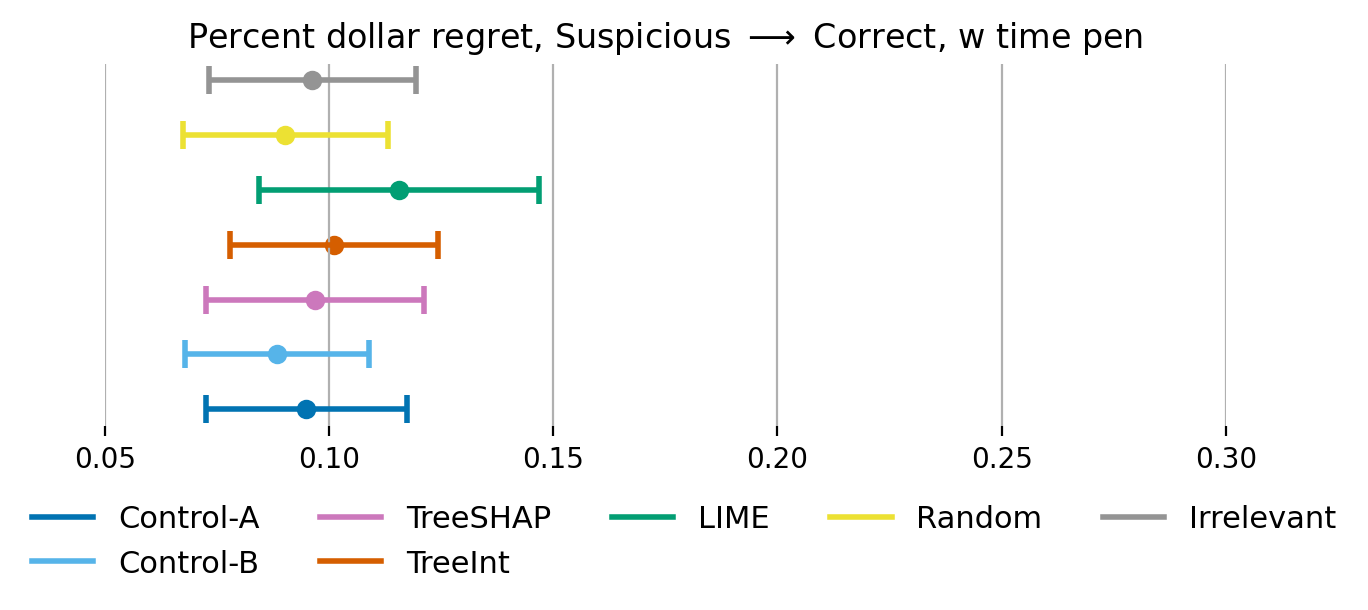

In [42]:
df = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Correct, w time pen', 
    legend=True,
    xlim=[0.05, 0.30]
)
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)

### We decided only to do the 'correct' ones
# df = pdr(all_decisions, params, 'approve', ['group'], n_samples=500, n_iterations=100)
# plot_metrics2(
#     df, group_order, colors, 
#     title='Percent dollar regret, Suspicious $\longrightarrow$ Approve', 
#     legend=True,
#     xlim=[0.05, 0.30]
# )
# ttests = ttests_operational_metrics(df, comparisons)
# print('approve')
# print_significant_tests(ttests)

# df = pdr(all_decisions, params, 'decline', ['group'], n_samples=500, n_iterations=100)
# plot_metrics2(
#     df, group_order, colors, 
#     title='Percent dollar regret, Suspicious $\longrightarrow$ Decline', 
#     legend=True,
#     xlim=[0.05, 0.30]
# )
# ttests = ttests_operational_metrics(df, comparisons)
# print('decline')
# print_significant_tests(ttests)

# df = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group'], n_samples=500, n_iterations=100)
# plot_metrics2(
#     df, group_order, colors, 
#     title='Percent dollar regret, Suspicious $\longrightarrow$ Ignore', 
#     legend=True,
#     xlim=[0.05, 0.30]
# )
# ttests = ttests_operational_metrics(df, comparisons)
# print('Ignore')
# print_significant_tests(ttests)

In [43]:
ttests

comparison     p-val    t-stat
0    (Control-A, Control-B)  0.727940  0.347966
1         (Control-B, LIME)  0.234159 -1.190435
2      (Control-B, TreeInt)  0.501412 -0.672516
3     (Control-B, TreeSHAP)  0.665632 -0.432280
4       (Control-B, Random)  0.925465 -0.093576
5   (Control-B, Irrelevant)  0.678503 -0.414629
6         (Random, TreeInt)  0.581393 -0.551532
7        (Random, TreeSHAP)  0.744250 -0.326321
8            (Random, LIME)  0.282582 -1.075121
9     (Irrelevant, TreeInt)  0.807472 -0.243754
10   (Irrelevant, TreeSHAP)  0.977704 -0.027954
11       (Irrelevant, LIME)  0.415133 -0.815234
12     (Irrelevant, Random)  0.759486  0.306240
13         (LIME, TreeSHAP)  0.437901  0.776055
14          (LIME, TreeInt)  0.542350  0.609474
15      (TreeSHAP, TreeInt)  0.834109 -0.209490

#### What's the worst PDR we could get for each arm? (using the current params)

In [20]:
dc = all_decisions.copy()
dc['conf_mat'] = assign_conf_mat_cell(dc, 'correct')

# flipping the predicitons to make them all wrong
dc['conf_mat'] = dc['conf_mat'].replace(['tp'], 'fn')
dc['conf_mat'] = dc['conf_mat'].replace(['tn'], 'fp')

coeffs = {
    'tp': 0,
    'tn': 1 + (params['cust_worth']) * params['p_return_cust'],
    'fn': params['fn'],
    'fp': (1 - params['p_loss_trx']) + (params['cust_worth'] * (1-params['p_loss_cust'])) # assuming the customer worth is on average n times the transaction value
}

dc['decision_value'] = dc.apply(lambda x: coeffs[x['conf_mat']]*x['trx_amnt'], axis=1)
dc['potential_revenue'] = dc.apply(
    lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
    axis=1
)


grpobj = dc.groupby(['group'])

for g, df in grpobj:
    regret = 1 - (df['decision_value'].sum() / df['potential_revenue'].sum())
    
    print(g, regret)

Control-A 0.3660560038248878
Control-B 0.41633188673817934
Irrelevant 0.3727866359329115
LIME 0.4811937309848231
Random 0.3850606498374367
TreeInt 0.4111262208143639
TreeSHAP 0.4098043521320045


#### Let's do a sweep of the parameters

We check two main things:
1. Do the rank order among the groups change with different parameter settings
2. Are the differences statistically significant even if the ranks change

In [76]:
param_grid = {
    'fn': [-1, -2, -3, -5, -6],
    'p_loss_trx': [0.3, 0.4, 0.5, 0.6], 
    'cust_worth': [0, 1, 3, 5], 
    'p_loss_cust': [0, 0.05, 0.1, 0.2], 
    'p_return_cust': [1, 0.8, 0.6, 0.4, 0.2],
    'suspicious_handling': [0, 600, 1800, 'approve', 'decline'] # If this is an int, it's correct and timepenalty
}

comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'LIME'),
    ('Control-B', 'TreeInt'),
    ('Control-B', 'TreeSHAP'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
    
]

In [77]:
def do_parameter_sweep(
    decisions, 
    group_cols,
    comparisons,
    fn,
    p_loss_trx, 
    cust_worth,
    p_loss_cust,
    p_return_cust,
    suspicious_handling
):
    all_param_combinations = itertools.product(
        fn, 
        p_loss_trx, 
        cust_worth, 
        p_loss_cust, 
        p_return_cust,
        suspicious_handling
    )

    results = list()
    significance_results = list()
    for config in all_param_combinations:
        
        # suspicious handling
        if isinstance(config[5], int):
            add_time= config[5]
            suspicious_strategy = 'correct'
        else:
            add_time= 0 # The value doesn't matter
            suspicious_strategy = config[5]
            
        
        param = {
            'fn': config[0],
            'p_loss_trx': config[1],
            'cust_worth': config[2],
            'p_loss_cust': config[3],
            'p_return_cust': config[4],
            'suspicious_add_time': add_time,
            'suspicious_strategy': suspicious_strategy
        }

        metrics = list()
        ttests = list()
        
        df = dt(decisions, param, suspicious_strategy, group_cols)
        df['metric'] = 'dt'
        
        ttest = ttests_operational_metrics(df, comparisons, group_cols[0])
        ttest['metric'] = 'dt'
        
        metrics.append(df)
        ttests.append(ttest)
        
        
# #         df = dps(decisions, param, suspicious_strategy, group_cols)
#         df['metric'] = 'dps'
        
#         ttest = ttests_operational_metrics(df, comparisons, group_cols[0])
#         ttest['metric'] = 'dps'
        
#         metrics.append(df)
#         ttests.append(ttest)
        
        df = pdr(decisions, param, suspicious_strategy, group_cols, n_iterations=1000)
        df['metric'] = 'pdr'
        
        ttest = ttests_operational_metrics(df, comparisons, group_cols[0])
        ttest['metric'] = 'pdr'
        
        metrics.append(df)
        ttests.append(ttest)
        
        res = pd.concat(metrics)
        sig_res = pd.concat(ttests)
        
        # appending the parameter values
        for p, v in param.items():
            res[p] = v
            sig_res[p] = v


        results.append(res)
        significance_results.append(sig_res)

    
    return pd.concat(results), pd.concat(significance_results)


**Cell below is commented out to stop accidentally running it**

In [78]:
# metrics, significance_tests = do_parameter_sweep(all_decisions, ['group'], comparisons, **param_grid)

# metrics.to_csv('param_sweep_op_metrics_new.csv', index=False)
# significance_tests.to_csv('param_sweep_significance_new.csv', index=False)

n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the gro

In [21]:
metrics_param_sweep = pd.read_csv('param_sweep_op_metrics_new.csv')


In [22]:
metrics_param_sweep['metric'].unique()

array(['dt', 'pdr'], dtype=object)

**We are only using the 'correct' configuration for Suspicious**

In [23]:
metrics_param_sweep = metrics_param_sweep[metrics_param_sweep['suspicious_strategy'] == 'correct']

In [24]:
significance_param_sweep = pd.read_csv('param_sweep_significance_new.csv')
# .drop(columns='Unnamed: 0')

In [25]:
cols = ['fn', 'p_loss_trx', 'cust_worth', 'p_loss_cust', 'p_return_cust', 'suspicious_add_time', 'suspicious_strategy']

In [26]:
s = pd.Series([str(x) for x in metrics_param_sweep[cols].to_dict('records')])
metrics_param_sweep['concat_hp'] = s

In [27]:
s = pd.Series([str(x) for x in significance_param_sweep[cols].to_dict('records')])
significance_param_sweep['concat_hp'] = s

In [28]:
# significance_param_sweep[significance_param_sweep['p_return_cust'] == 1]

In [29]:
significance_param_sweep['comparison'].unique()

array(["('Control-A', 'Control-B')", "('Control-B', 'LIME')",
       "('Control-B', 'TreeInt')", "('Control-B', 'TreeSHAP')",
       "('Control-B', 'Random')", "('Control-B', 'Irrelevant')",
       "('Random', 'TreeInt')", "('Random', 'TreeSHAP')",
       "('Random', 'LIME')", "('Irrelevant', 'TreeInt')",
       "('Irrelevant', 'TreeSHAP')", "('Irrelevant', 'LIME')",
       "('Irrelevant', 'Random')", "('LIME', 'TreeSHAP')",
       "('LIME', 'TreeInt')", "('TreeSHAP', 'TreeInt')"], dtype=object)

### PDR -- Are any of the parameters result in statistically significant results?

Here, we look filter out the statistically insignificant comparisons, and parameter combinations, and observe how the metric value change with each parameter

No significant differences for Control-A vs Control-B
No significant differences for Control-B vs Irrelevant
Control-B vs LIME: 132 out of 240 configurations yielded significant results
No significant differences for Control-B vs Random
No significant differences for Control-B vs TreeInt
Control-B vs TreeSHAP: 100 out of 240 configurations yielded significant results
No significant differences for Irrelevant vs LIME
No significant differences for Irrelevant vs Random
No significant differences for Irrelevant vs TreeInt
No significant differences for Irrelevant vs TreeSHAP
No significant differences for LIME vs TreeInt
No significant differences for LIME vs TreeSHAP
No significant differences for Random vs LIME
No significant differences for Random vs TreeInt
No significant differences for Random vs TreeSHAP
No significant differences for TreeSHAP vs TreeInt


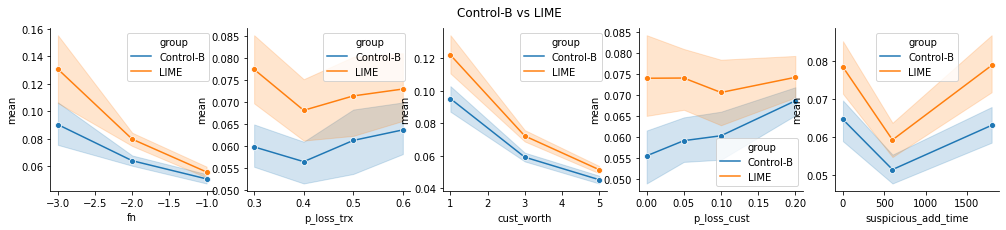

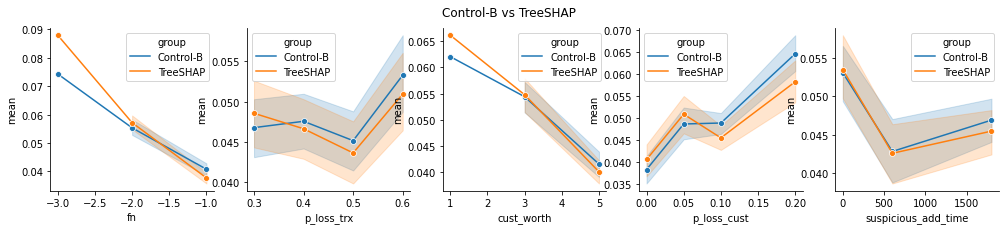

In [41]:
# grp_obj = significance_param_sweep[metric_msk].groupby(['comparison'])
msk = (metrics_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['suspicious_strategy'] == 'correct') & (metrics_param_sweep['p_return_cust'] == 1)
metrics = metrics_param_sweep[msk]

cols = ['fn', 'p_loss_trx', 'cust_worth', 'p_loss_cust', 'suspicious_add_time']


# We are not really talking about the p_return_cust variable in the paper
metric_msk = (significance_param_sweep['metric'] == 'pdr') & (significance_param_sweep['suspicious_strategy'] == 'correct') & (metrics_param_sweep['p_return_cust'] == 1)

# metric_msk = (significance_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['p_return_cust'] == 1)

grp_obj = significance_param_sweep[metric_msk].groupby(['comparison'])

for g, df in grp_obj:
    groups = g.replace("'", "").strip("()").split(', ')
    msk = (df['p-val'] <= 0.05)
    
    # for plotting everything
#     msk = (df['p-val'] <= 1)
    
    if df[msk].empty:
        print('No significant differences for {} vs {}'.format(groups[0], groups[1]))
        continue
    
#     print(df[msk]['p_return_cust'].unique())
    msk2 = ((metrics['group'] == groups[0]) | (metrics['group'] == groups[1])) 
        
    df2 = metrics[msk2].merge(df[msk], on=cols, how='inner')

    print('{} vs {}: {} out of {} configurations yielded significant results'.format(groups[0], groups[1], len(df2), len(df)))
    
    if df2.empty:
        continue
            
#     print(df2['p_return_cust'].unique())
    
    fig, ax = plt.subplots(1, 5, figsize=(17, 3))
    for i, c in enumerate(cols):
        sns.lineplot(
            data=df2,
            x= c,
            y='mean',
            hue='group',
            ax=ax[i],
            marker='o',
            ci=68
        )
#         sns.distplot(
#             gdf[p],
#             ax=ax[i],
#             kde=False,
#             bins=100
#         )
#         ax[i].set_title(df2[c + '_x'].mean())
        sns.despine()
    fig.suptitle(' vs '.join(groups))
    
#     print("----")
    

In [31]:
(1 * 0.64) + (2 * 0.16) + (3 * 0.06) + (4 * 0.036) + (5 * 0.02) + (6 * 0.06)

1.7439999999999998

#### What's the distribution of the PDR metric and where does our parameter choice fall?

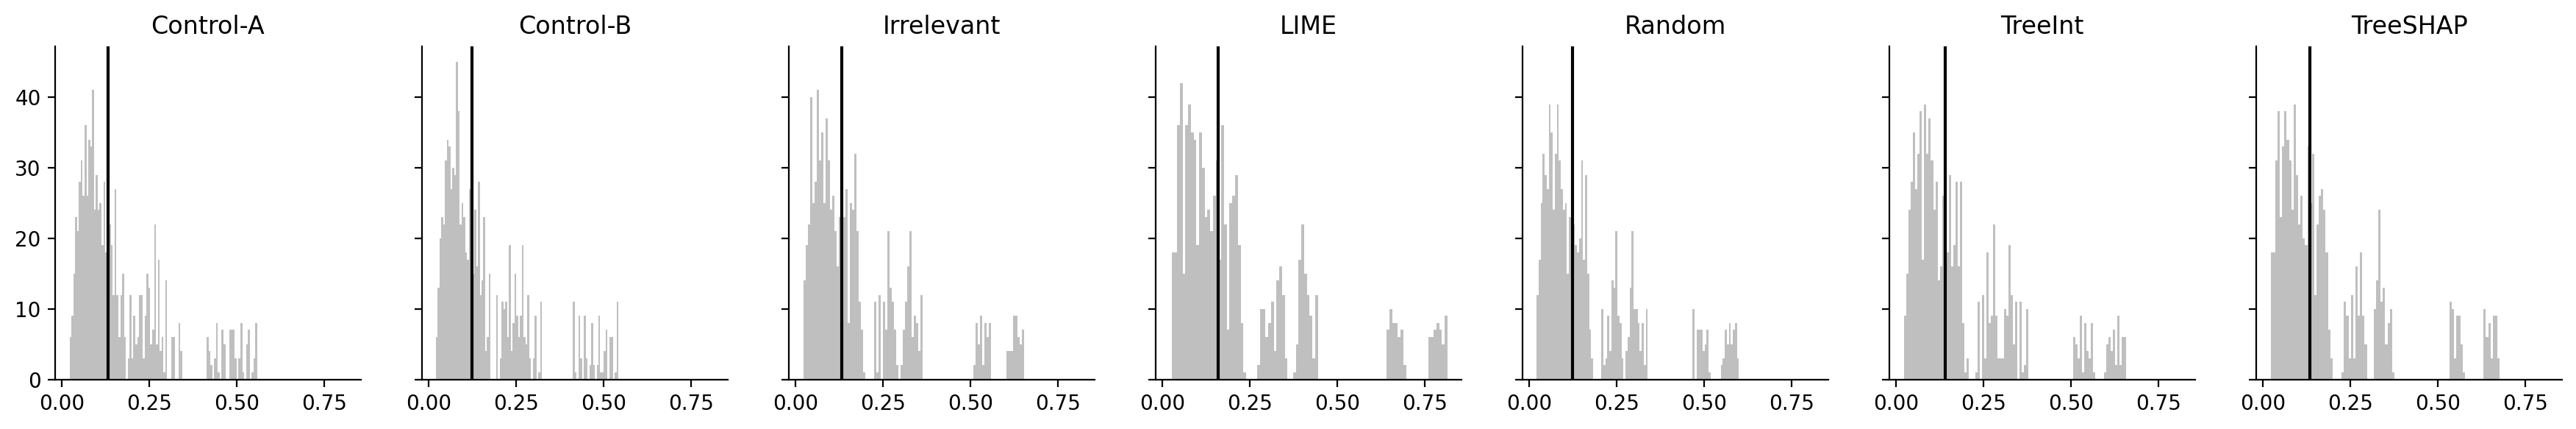

In [44]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

df = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)

# msk = (metrics_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['suspicious_strategy'] == 'correct') & (metrics_param_sweep['p_return_cust'] == 1)
msk = (metrics_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['p_return_cust'] == 1)
metrics =  metrics_param_sweep[msk]
grp_obj = metrics.groupby(['metric', 'group'])
fig, axes = plt.subplots(1, 7, figsize=(22, 3), sharex=True, sharey=True, dpi=200)
i=0
for g, df in grp_obj:
    if g[0] == 'pdr':
        df['mean'].hist(ax=axes[i], bins=100, grid=False, color='gray', alpha=0.5)
        axes[i].set_title(g[1])
        
        msk = df['group'] == g[1]
        val = df[msk]['mean'].iloc[0]
        
        axes[i].axvline(x=val, color='k')
        sns.despine()
        i = i + 1

##### When do we have very high regret values?

            group      mean    n        se       var metric  fn  p_loss_trx  \
100814  Control-A  0.421120  495  0.084993  3.575744    pdr  -5         0.3   
100835  Control-A  0.419285  495  0.078912  3.082444    pdr  -5         0.3   
100856  Control-A  0.418151  495  0.082962  3.406906    pdr  -5         0.3   
101339  Control-A  0.424021  495  0.081204  3.264058    pdr  -5         0.3   
101360  Control-A  0.419349  495  0.082420  3.362534    pdr  -5         0.3   

        cust_worth  p_loss_cust  p_return_cust  suspicious_add_time  \
100814           0         0.00            1.0                    0   
100835           0         0.00            1.0                  600   
100856           0         0.00            1.0                 1800   
101339           0         0.05            1.0                    0   
101360           0         0.05            1.0                  600   

       suspicious_strategy concat_hp  
100814             correct       NaN  
100835             c

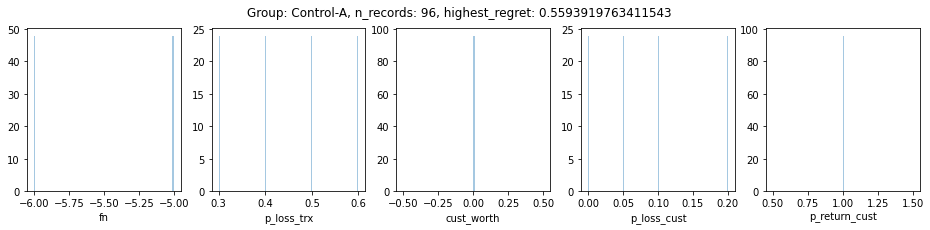

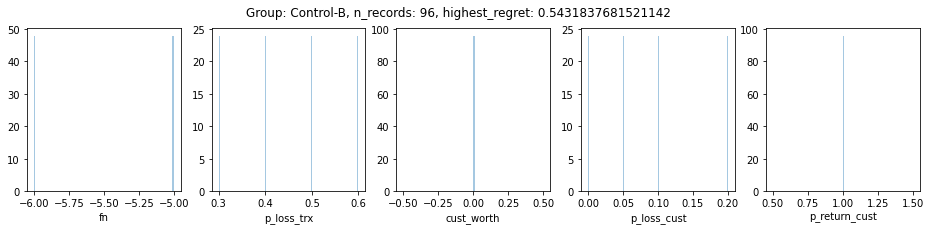

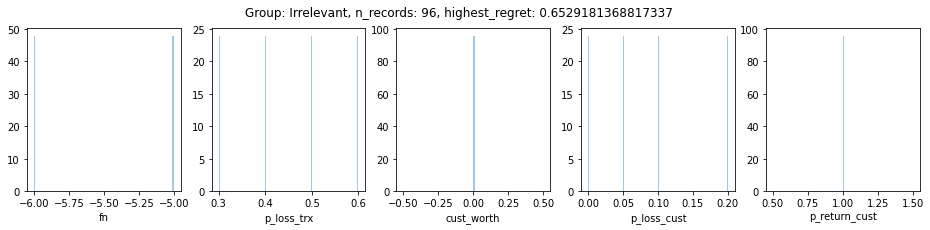

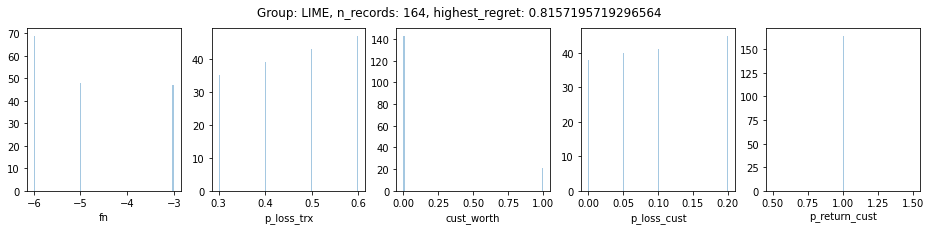

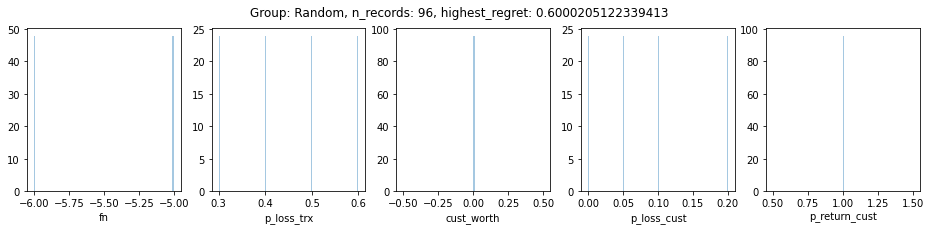

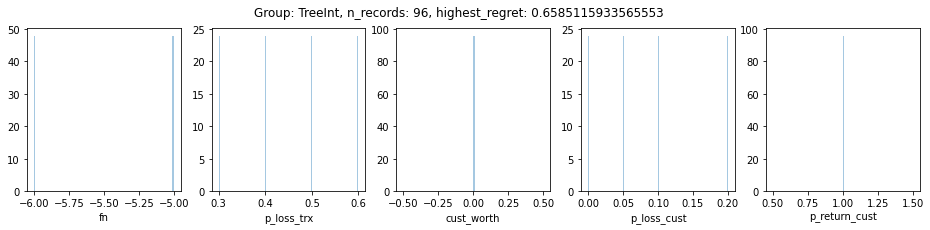

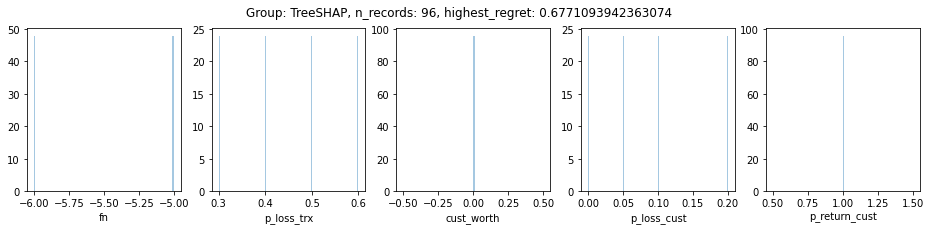

In [165]:
msk = (metrics_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['suspicious_strategy'] == 'correct') & (metrics_param_sweep['p_return_cust'] == 1)
df = metrics_param_sweep[msk]

msk = (df['mean'] > 0.4)

# param_names = list(params.keys())
grp_object = df[msk].groupby('group')
cols = ['fn', 'p_loss_trx', 'cust_worth', 'p_loss_cust', 'p_return_cust']
for g, gdf in grp_object:
    fig, ax = plt.subplots(1, 5, figsize=(16, 3))
    print(gdf.head())
    for i, p in enumerate(cols):
        sns.distplot(
            gdf[p],
            ax=ax[i],
            kde=False,
            bins=100
        )
    n_records = len(gdf)
    highest_regret = gdf['mean'].max()
    fig.suptitle('Group: {}, n_records: {}, highest_regret: {}'.format(g, n_records, highest_regret))
      

Seems like when the regret is really high, the FN weight is very high, and p_return_cust is 0, p_loss_cust is high

We penalize for long term effects in FN and FP without adding it to TN 

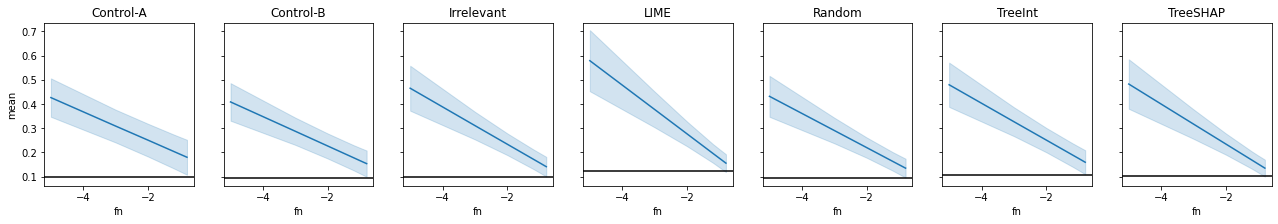

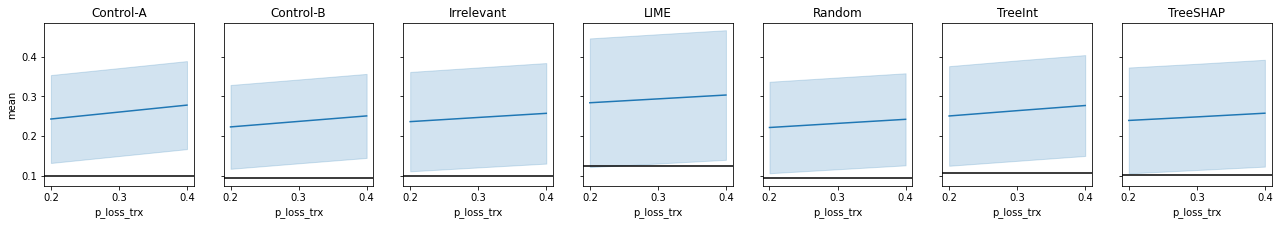

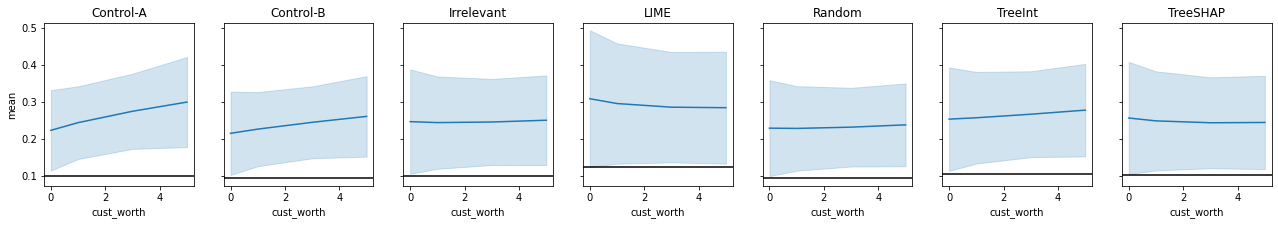

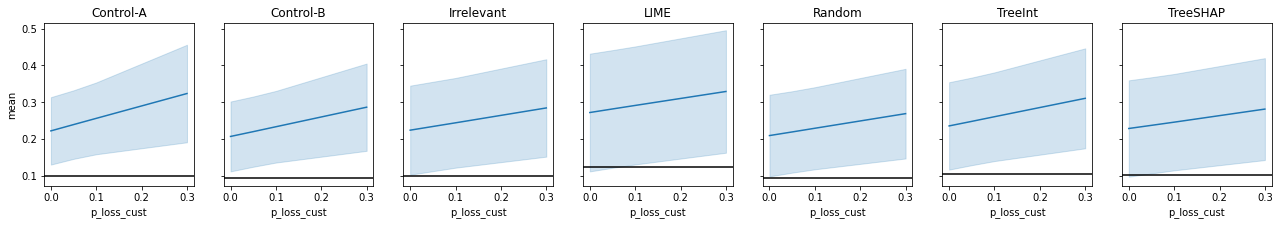

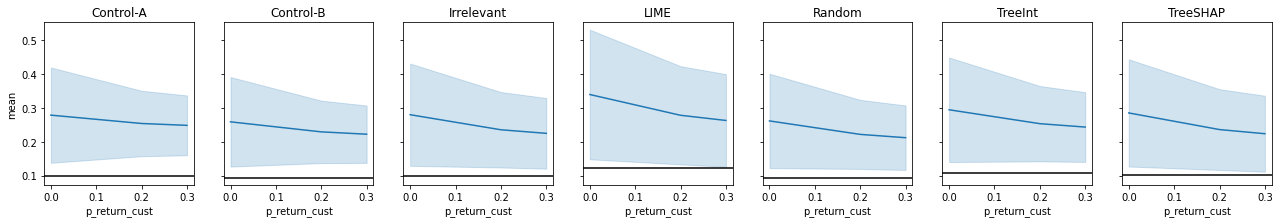

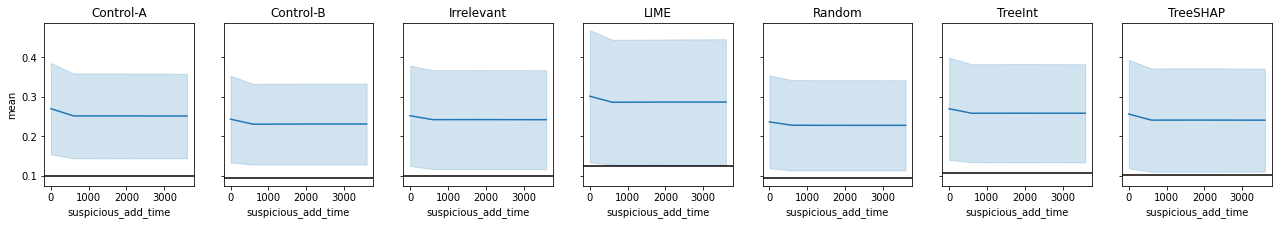

In [143]:
grp_obj = metrics_param_sweep.groupby(['metric', 'group'])


for k in params.keys():
    fig, axes = plt.subplots(1, 7, figsize=(22, 3), sharex=True, sharey=True)
    i=0
    for g, df in grp_obj:

        if g[0] != 'pdr':
            continue
 
        sns.lineplot(
            data=df,
            x=k,
            y='mean',
            ax=axes[i],
            ci='sd'
        )
        axes[i].set_title(g[1])
        msk = df['group'] == g[1]
        val = df[msk]['mean'].iloc[0]
        axes[i].axhline(y=val, color='k')
        i = i +1

#### Can we check for significant changes within a "sensible" hypercube of parameter values?

In [56]:
params_ranges={
    'fn': [-1.2, -0.8],
    'p_loss_trx': [0.1, 0.3] , # prob of losing this transaction
    'cust_worth': [0, 2], # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': [0.1, 0.3], # probablity of losing the customer due to the rejection
    'p_return_cust': [0.1, 1], # probability of the customer creating future worth as we expect
    'suspicious_add_time': [600, 1800]
}

cols = ['fn', 'p_loss_trx', 'cust_worth', 'p_loss_cust', 'p_return_cust', 'suspicious_add_time', 'suspicious_strategy']

In [57]:
grp_obj = significance_param_sweep.groupby(['comparison', 'metric'])

In [58]:
for g, df in grp_obj:
    
    groups = g[0].replace("'", "").strip("()").split(', ')
    msk = ((df['p-val'] <= 0.1) & (df['metric'] == 'pdr'))
    
#     if not df[df['metric']=='pdr'].empty:
#         print(g)
    
    if df[msk].empty:
        continue
        
    
    
    
#     print(groups)
    msk2 = ((metrics_param_sweep['group'] == groups[0]) | (metrics_param_sweep['group'] == groups[1])) & (metrics_param_sweep['metric'] == 'pdr')
    
    df2 = metrics_param_sweep[msk2].merge(df[msk], on='concat_hp', how='inner')

    param_mask = None

    for k, v in params_ranges.items():
        k = k + '_x' # because of the merge
        if param_mask is None:
            param_mask = ((df2[k] >= v[0]) & (df2[k] <= v[1]))

        else:
            param_mask &= ((df2[k] >= v[0]) & (df2[k] <= v[1]))
            
    df3 = df2[param_mask]
    
    if df3.empty:
        print("Nothing falls inside the hypercube", g)
        continue
        
    fig, ax = plt.subplots(1, 7, figsize=(21, 3))
    for i, c in enumerate(cols):
        sns.lineplot(
            data=df3,
            x= c + '_x',
            y='mean',
            hue='group',
            ax=ax[i],
            marker='o'
        )
#         ax[i].set_title(g[0])
        sns.despine()
    fig.suptitle(' vs '.join(groups))
    

Nothing falls inside the hypercube ("('Control-A', 'Control-B')", 'pdr')
Nothing falls inside the hypercube ("('Control-B', 'LIME')", 'pdr')
Nothing falls inside the hypercube ("('Control-B', 'TreeSHAP')", 'pdr')
Nothing falls inside the hypercube ("('Irrelevant', 'LIME')", 'pdr')
Nothing falls inside the hypercube ("('Random', 'LIME')", 'pdr')


#### How DPS changes with the parameters

Here, we look filter out the statistically insignificant comparisons, and parameter combinations, and observe how the metric value change with each parameter

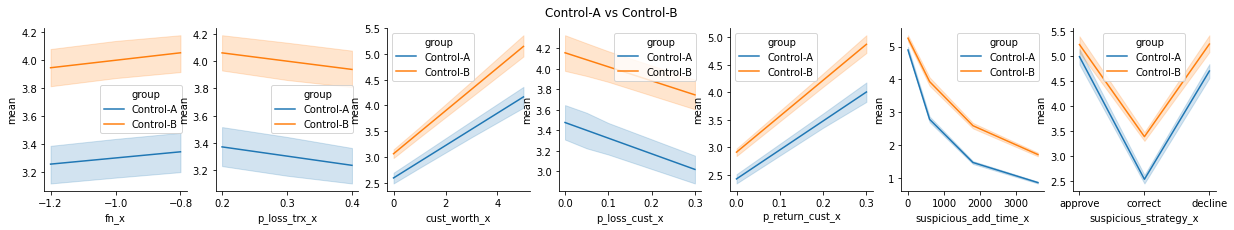

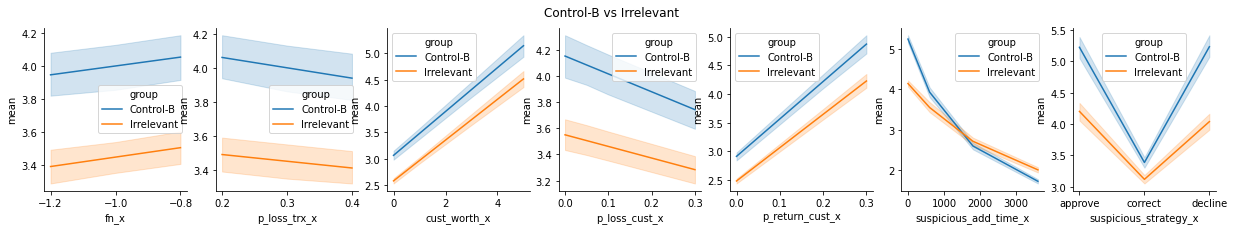

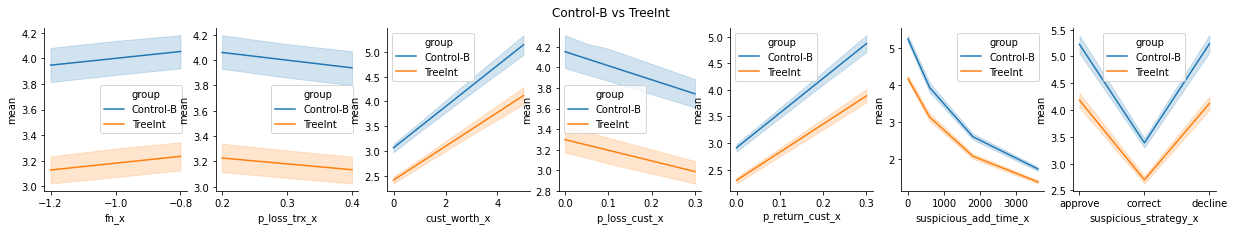

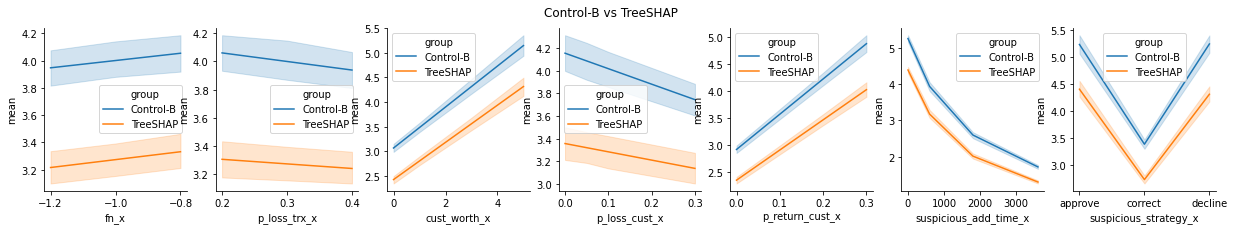

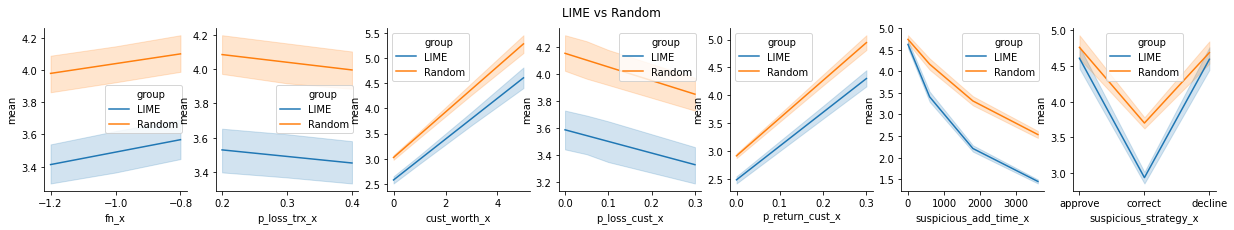

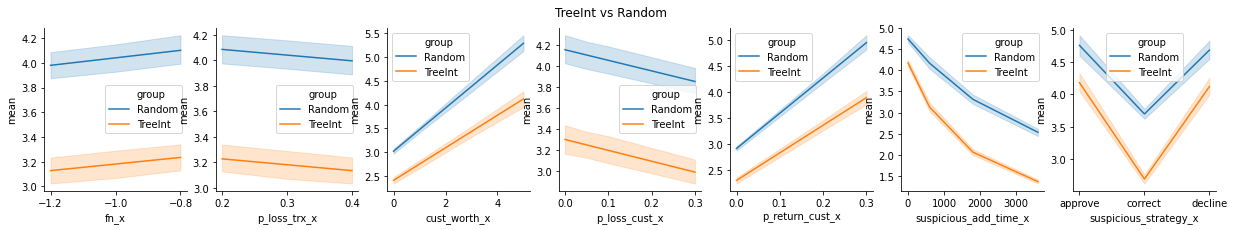

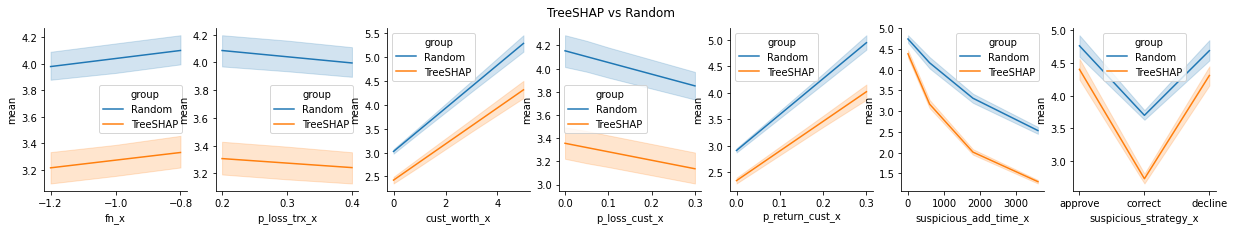

In [195]:
for g, df in grp_obj:
    groups = g[0].replace("'", "").strip("()").split(', ')
    msk = (df['p-val'] <= 0.1) & (df['metric'] == 'dps')
    if df[msk].empty:
        continue
    msk2 = ((metrics_param_sweep['group'] == groups[0]) | (metrics_param_sweep['group'] == groups[1])) & (metrics_param_sweep['metric'] == 'dps')
    
    df2 = metrics_param_sweep[msk2].merge(df, on='concat_hp', how='left')
    
    if df2.empty:
        continue
        
    fig, ax = plt.subplots(1, 7, figsize=(21, 3))
    for i, c in enumerate(cols):
        sns.lineplot(
            data=df2,
            x= c + '_x',
            y='mean',
            hue='group',
            ax=ax[i]
        )
#         ax[i].set_title(g[0])
        sns.despine()
    fig.suptitle(' vs '.join(groups))
    
    
#     print(df[msk]['comparison'].unique())

#     print(df[msk]['fn'].unique())
#     print(df[msk]['cust_worth'].unique())
#     print(df[msk]['p_loss_trx'].unique()) 
#     print(df[msk]['suspicious_strategy'].unique())
#     print(df[msk]['p_return_cust'].unique()) 
#     print(df[msk]['p_loss_cust'].unique()) 
#     print(len(df[msk]), len(df))
    
#     print("----")

In [175]:
msk = (metrics_param_sweep['group'] == 'Control-B') & (metrics_param_sweep['metric'] == 'pdr')
metrics_param_sweep[msk].head()

group      mean    n        se       var metric   fn  p_loss_trx  \
15  Control-B  0.091507  499  0.012231  0.074648    pdr -0.8         0.2   
36  Control-B  0.092091  499  0.012694  0.080402    pdr -0.8         0.2   
57  Control-B  0.093117  499  0.012314  0.075667    pdr -0.8         0.2   
78  Control-B  0.091860  499  0.012013  0.072017    pdr -0.8         0.2   
99  Control-B  0.103575  499  0.016139  0.129969    pdr -0.8         0.2   

    cust_worth  p_loss_cust  p_return_cust  suspicious_add_time  \
15           0          0.0            0.0                    0   
36           0          0.0            0.0                  600   
57           0          0.0            0.0                 1800   
78           0          0.0            0.0                 3600   
99           0          0.0            0.0                    0   

   suspicious_strategy                                          concat_hp  
15             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
36             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
57             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
78             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
99             approve  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...

In [130]:
significance_param_sweep.head()

comparison     p-val    t-stat metric   fn  p_loss_trx  \
0  ('Control-A', 'Control-B')  0.005227  2.798930     dt -0.8         0.2   
1       ('Control-B', 'LIME')  0.082231 -1.739641     dt -0.8         0.2   
2    ('Control-B', 'TreeInt')  0.000063 -4.017922     dt -0.8         0.2   
3   ('Control-B', 'TreeSHAP')  0.000062 -4.023300     dt -0.8         0.2   
4     ('Control-B', 'Random')  0.000015 -4.350453     dt -0.8         0.2   

   cust_worth  p_loss_cust  p_return_cust  suspicious_add_time  \
0           0          0.0            0.0                    0   
1           0          0.0            0.0                    0   
2           0          0.0            0.0                    0   
3           0          0.0            0.0                    0   
4           0          0.0            0.0                    0   

  suspicious_strategy                                          concat_hp  
0             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
1             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
2             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
3             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...  
4             correct  {'fn': -0.8, 'p_loss_trx': 0.2, 'cust_worth': ...

#### Revenue vs Time

In [26]:
def get_decision_rev(decisions, params, suspicious_strategy, agg_levels=['group']):
    dcs = _modify_value_and_time(decisions, params, suspicious_strategy)
    
    grpobj = dcs.groupby(agg_levels)
    
    res = list()
    
    for g, df in grpobj:
        d = dict()

        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
        
        d['mean'] = df['decision_value'].mean() 
        d['var'] = df['decision_value'].std() ** 2
        d['se'] = np.sqrt(d['var']/len(df))
        d['n'] = len(df)
        
        res.append(d)
        
    return pd.DataFrame(res)
        

def plot_time_vs_op_metric(op_metric, time_metric, group_order, title='', ylabel='', confidence=0.9, xlim=[], ylim=[]):
    
    merged = op_metric.merge(
        time_metric, on='group', suffixes=('_met', '_dt')
    )
    
    fig, ax = plt.subplots(dpi=200)
    
    for i, g in enumerate(group_order):
        msk = merged['group'] == g
        df = merged[msk]
        
        interval = stats.norm.ppf(1-(1-confidence)/2)
        
        ax.errorbar(
            df['mean_dt'],
            df['mean_met'],
            yerr=df['se_met'] * interval,
            xerr=df['se_dt'] * interval,
            color=colors[i]
        )
        ax.scatter(df['mean_dt'], df['mean_met'], color=colors[i], label=g)

    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Decision Time')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
    sns.despine()

    

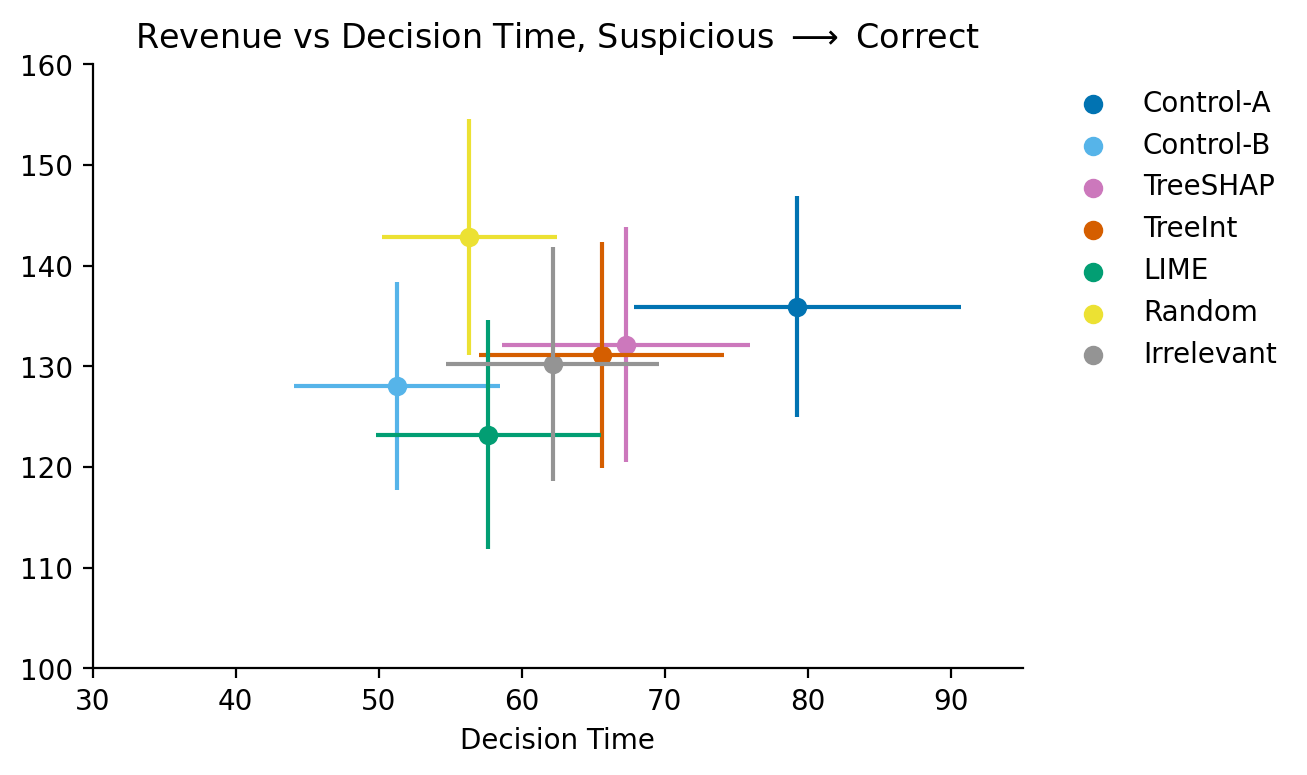

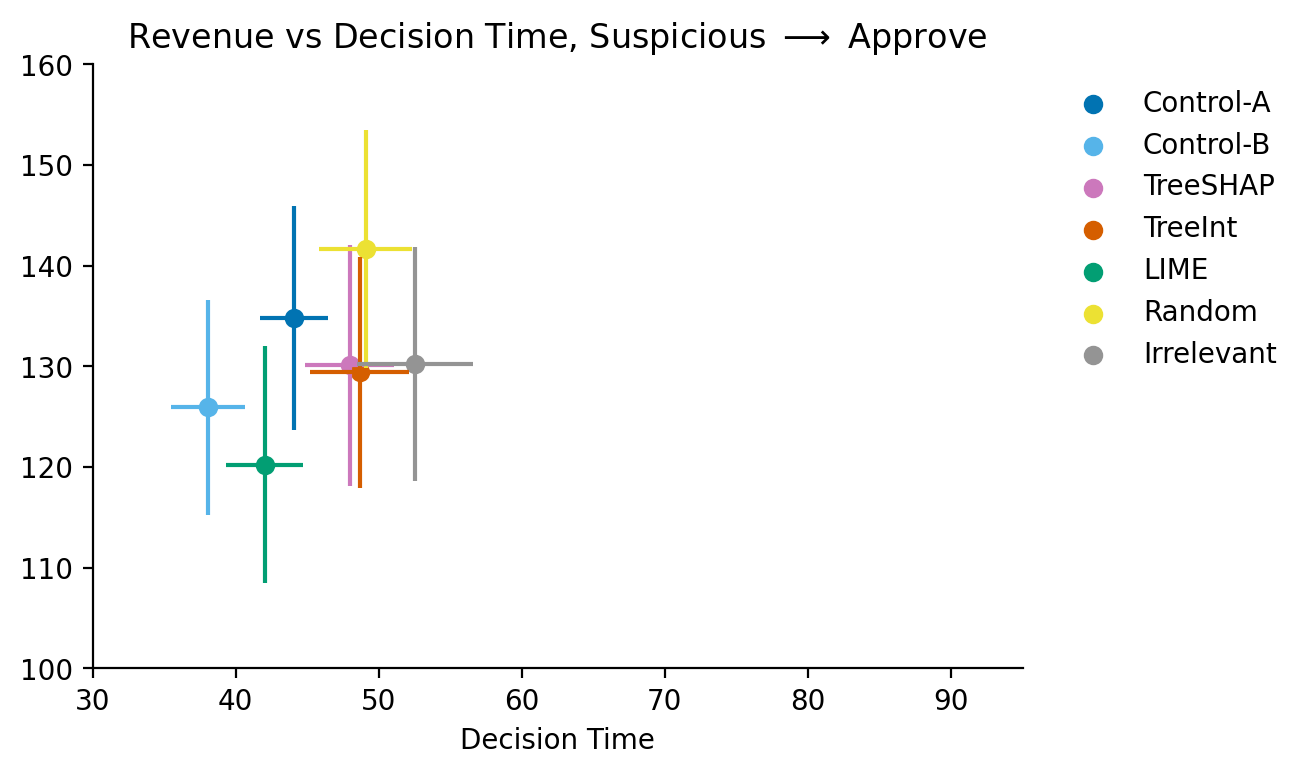

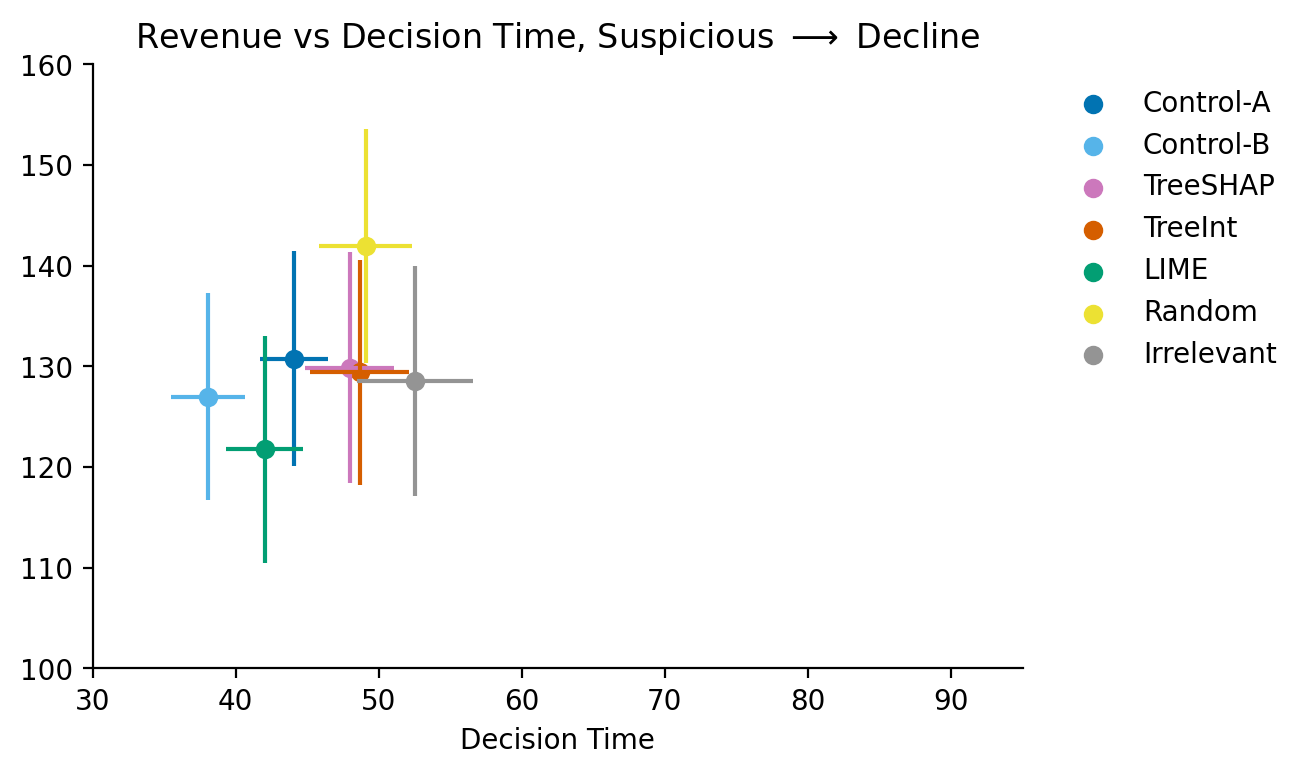

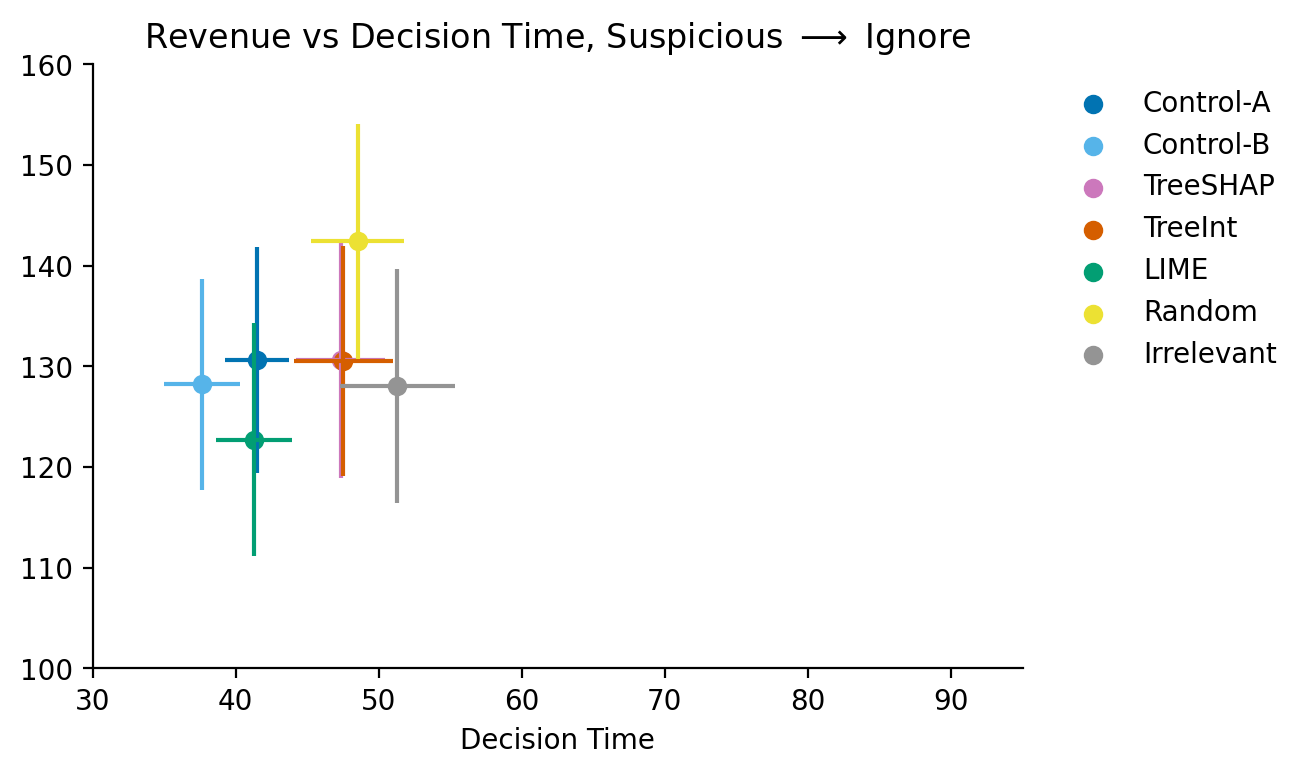

In [94]:
xlim = [30, 95]
ylim = [100, 160]


rev = get_decision_rev(all_decisions, params, 'correct', ['group'])
time = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions, params, 'approve', ['group'])
time = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions, params, 'decline', ['group'])
time = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Dollar Regret vs Time

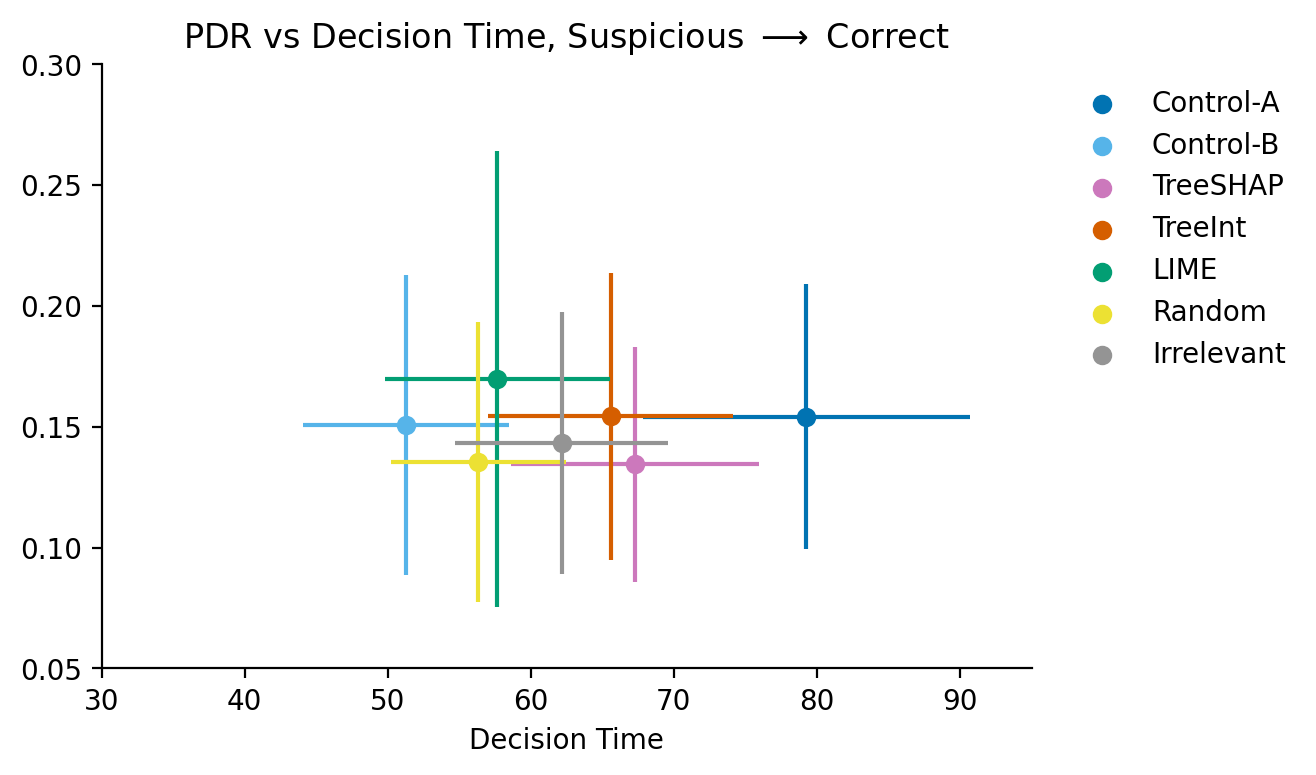

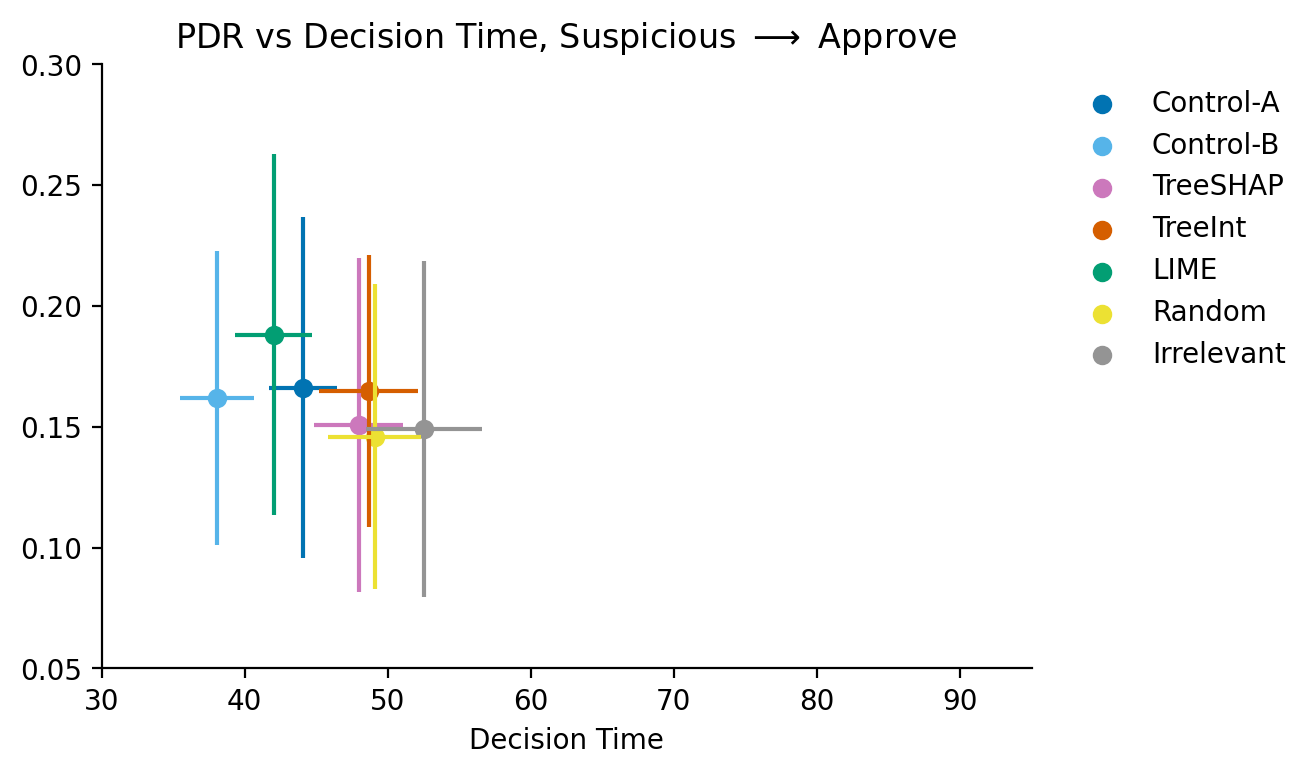

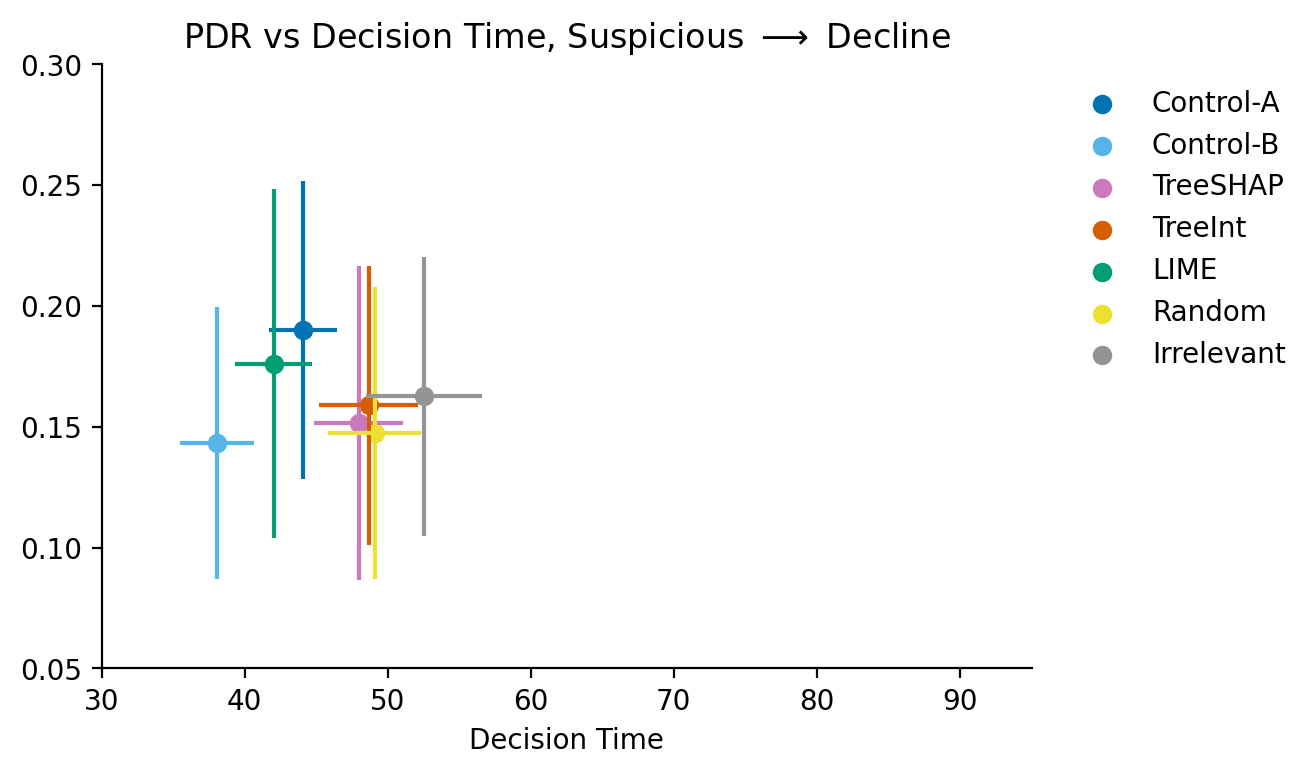

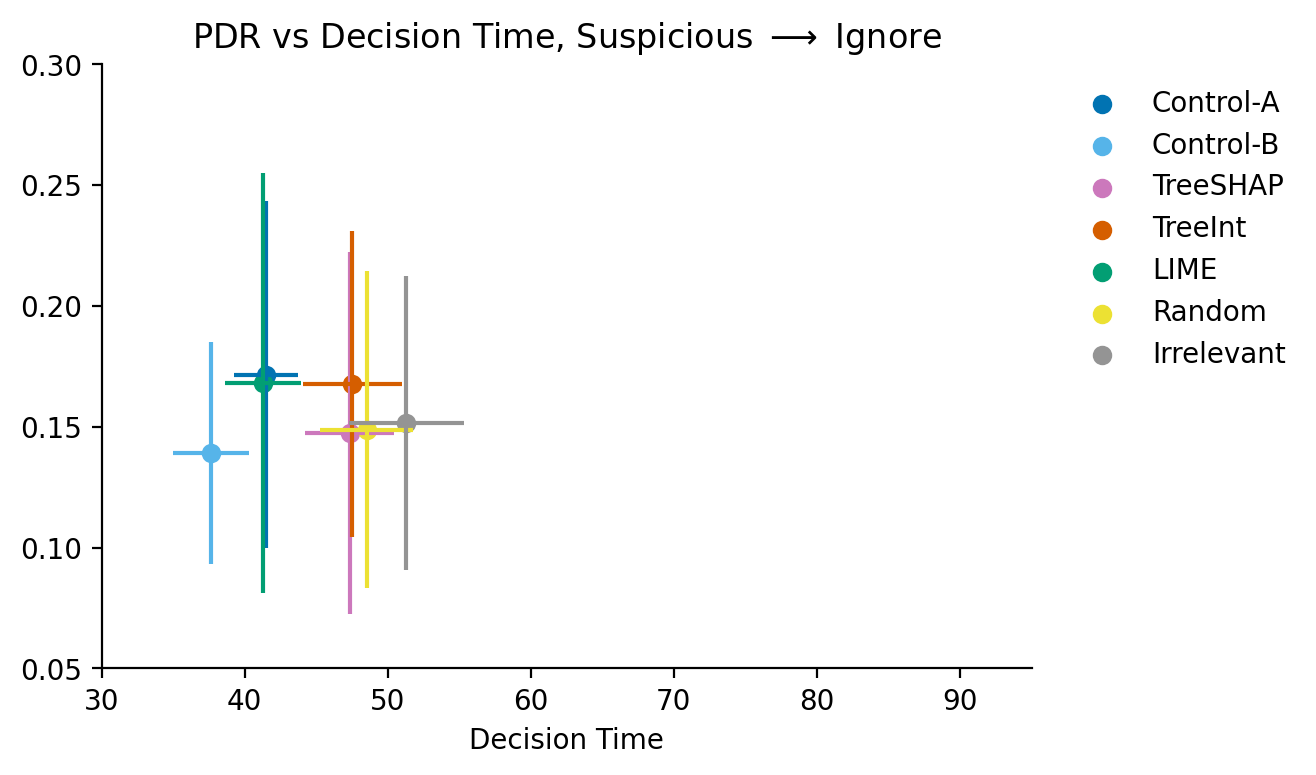

In [82]:
xlim = [30, 95]
ylim = [0.05, 0.3]


regret = pdr(all_decisions, params, 'correct', ['group'])
time = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions, params, 'approve', ['group'])
time = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions, params, 'decline', ['group'])
time = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Considering only T and J -- PDR vs Time

/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


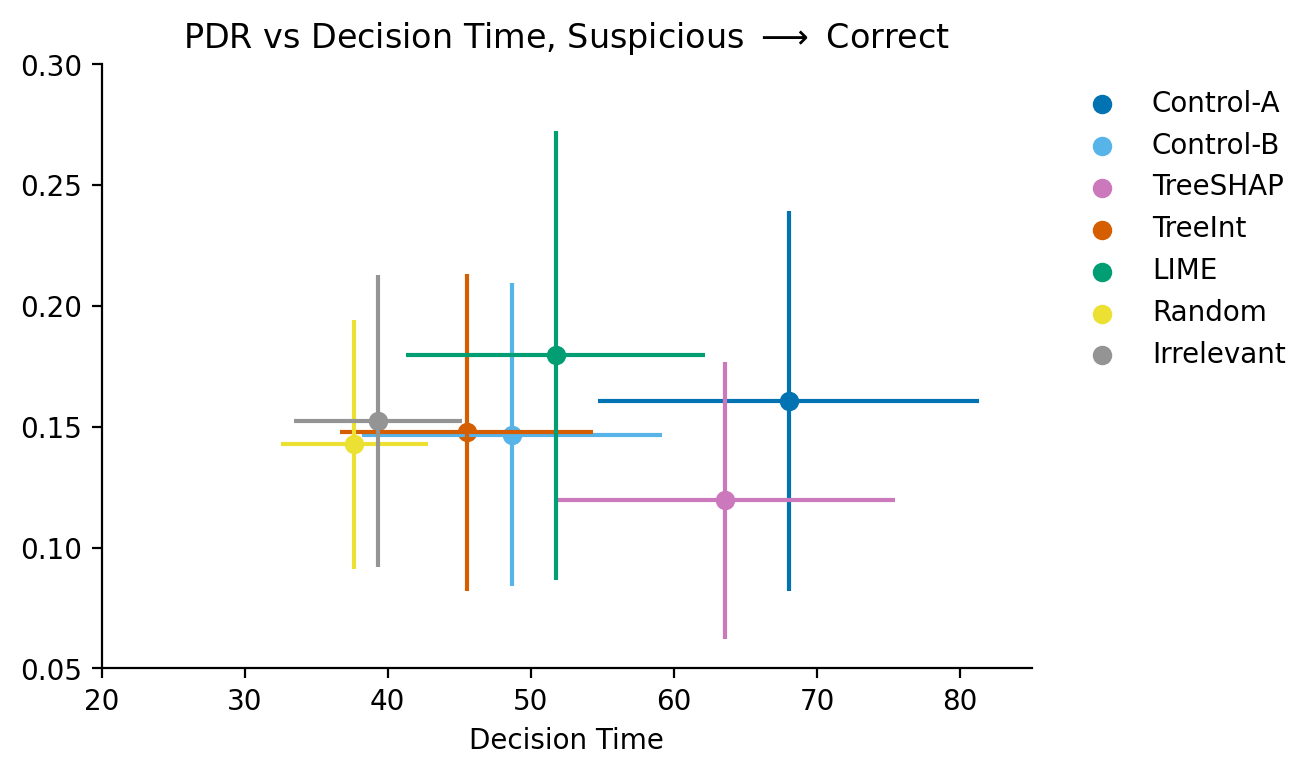

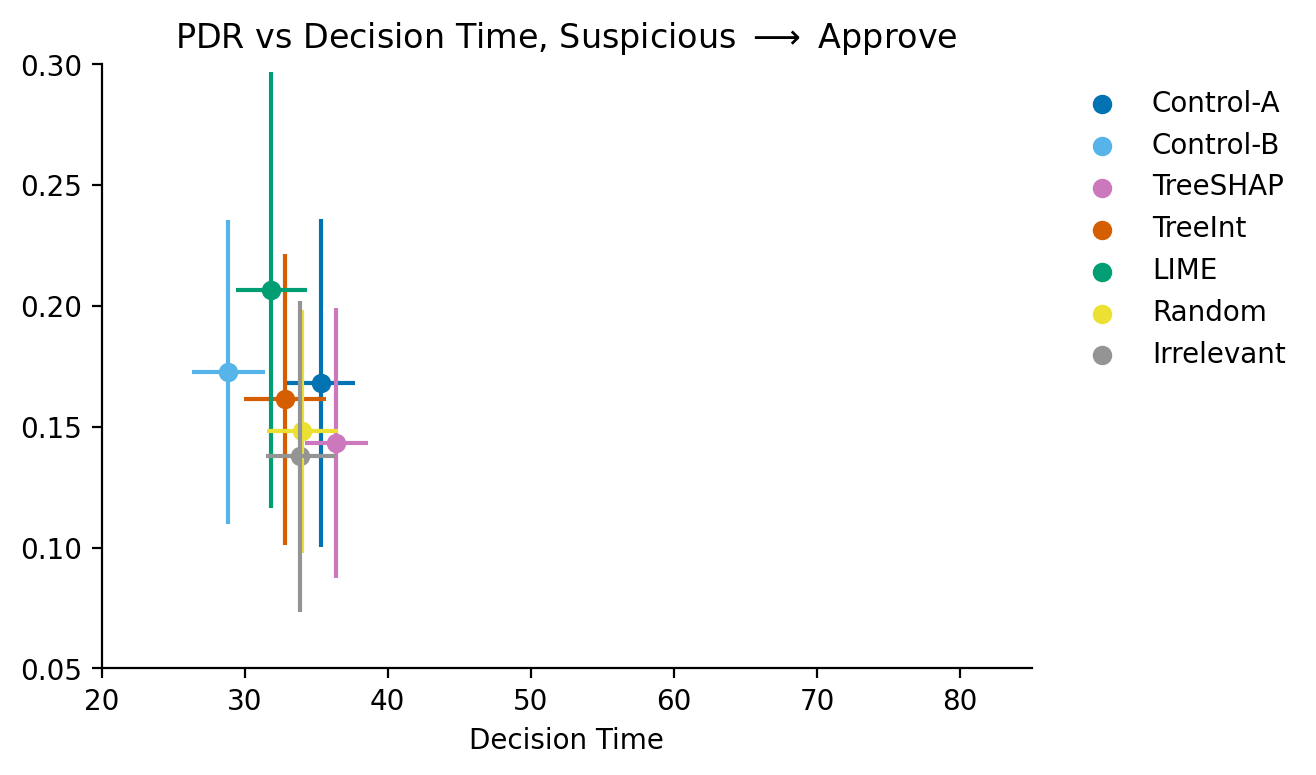

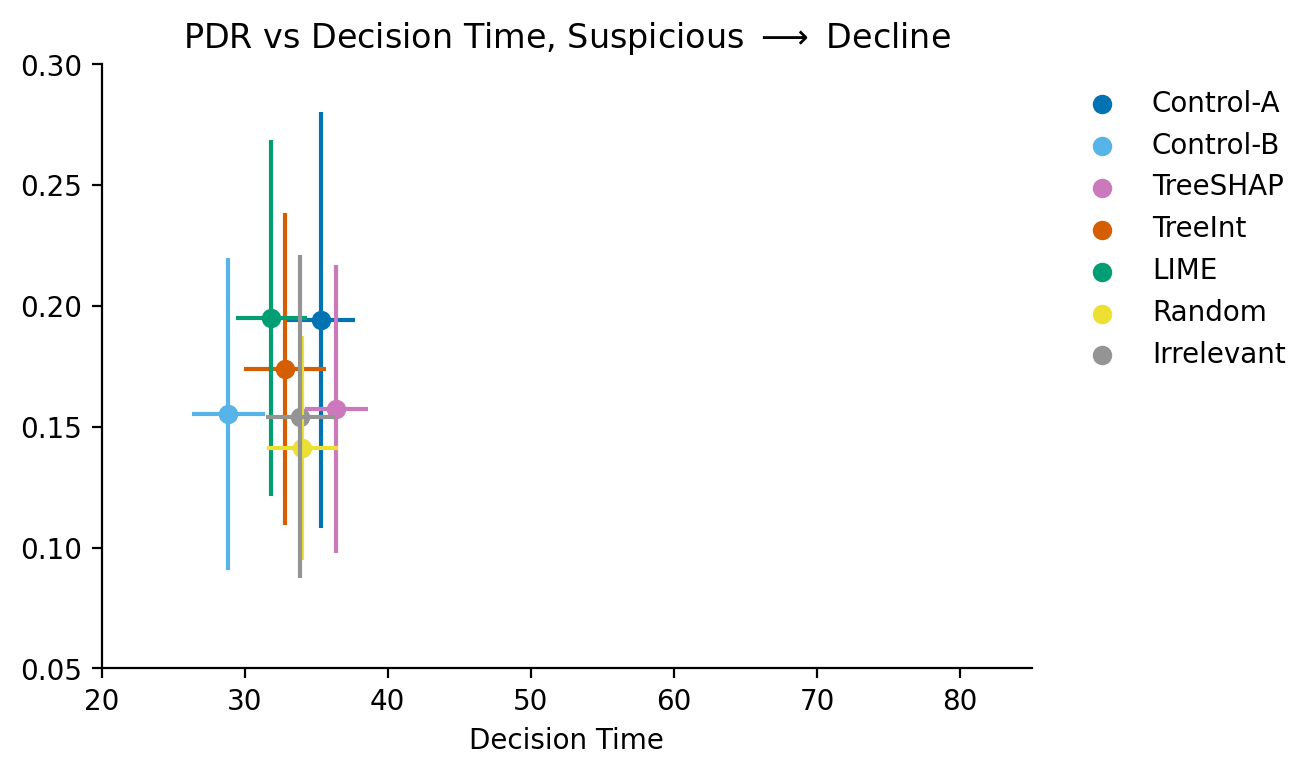

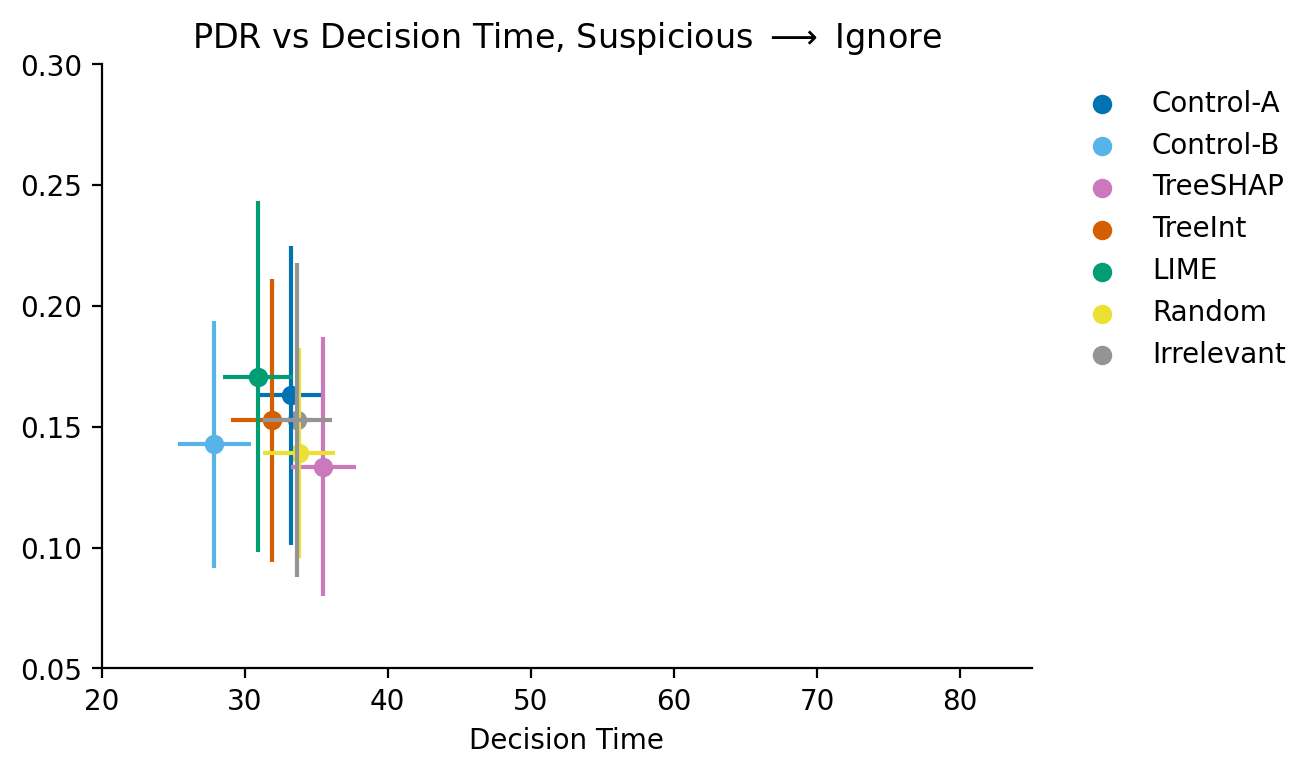

In [85]:
n_msk = all_decisions['user_name'] == 'n'

jt_decisions = all_decisions[~n_msk]

xlim = [20, 85]
ylim = [0.05, 0.3]

regret = pdr(jt_decisions, params, 'correct', ['group'])
time = dt(jt_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions, params, 'approve', ['group'])
time = dt(jt_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions, params, 'decline', ['group'])
time = dt(jt_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(jt_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Possible revenue distribution across arms

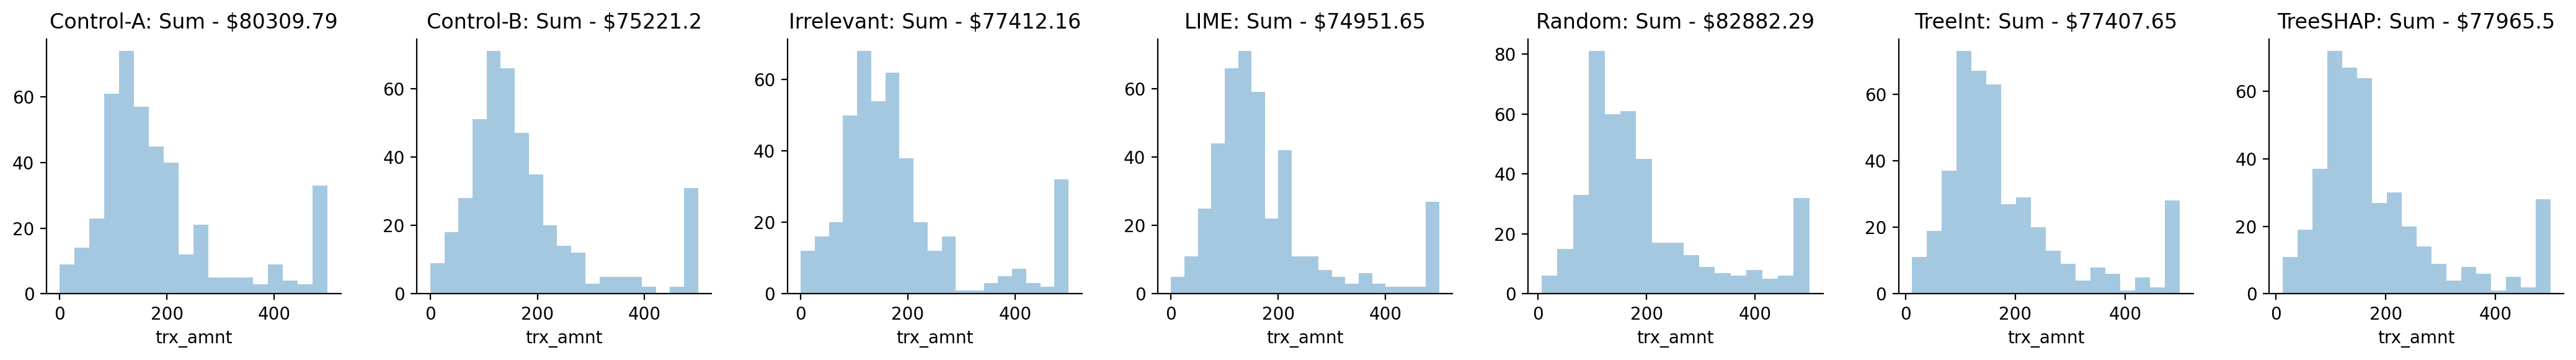

In [58]:
grp_obj = all_decisions.groupby('group')

fig, axes = plt.subplots(1, 7, figsize=(21, 3), dpi=200)
i = 0
for g, df in grp_obj:
    msk = df['label'] == 0
    ax = sns.distplot(df[msk]['trx_amnt'], kde=False, ax = axes[i])
    possible_rev = df[msk]['trx_amnt'].sum()
    title = '{}: Sum - ${}'.format(g, round(possible_rev, 2))
    ax.set_title(title)
    sns.despine()
    i = i + 1
    
plt.tight_layout()

In [59]:
all_decisions['trx_amnt'].max()

500.0

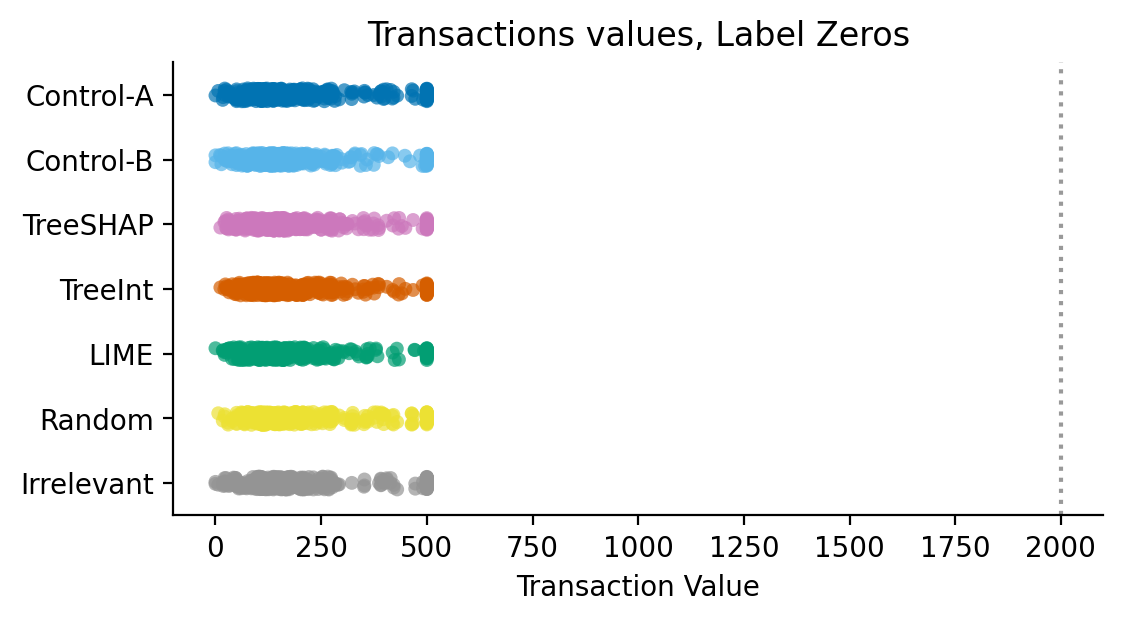

In [95]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=200)
msk = all_decisions['label'] == 0
sns.stripplot(
    x="trx_amnt", y="group", 
    data=all_decisions[msk], alpha=0.7, 
    palette=colors, order=group_order)
plt.axvline(x=2000, color='k', linestyle=':', alpha=0.4)
sns.despine()

t = plt.title('Transactions values, Label Zeros')
axes.set_xlabel('Transaction Value')
t = axes.set_ylabel('')

#### TODO

- Recreate these plot for value bins
- Cap the values at 500
- Figure out plots to show how the parameter sweep worked
- Combine the explainers into one group and plot again
- The model threshold for each param configuration

### Combining Explainers into one group

In [87]:
def group_explainers(row):
    if row['group'] in {'LIME', 'TreeSHAP', 'TreeInt'}:
        return 'Explainer'
    else:
        return row['group']
    
    
all_decisions['group2'] = all_decisions.apply(lambda x: group_explainers(x), axis=1)

In [88]:
params={
    'fn': -1, 
    'p_loss_trx': 0.3, # prob of losing this transaction
    'cust_worth': 0, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

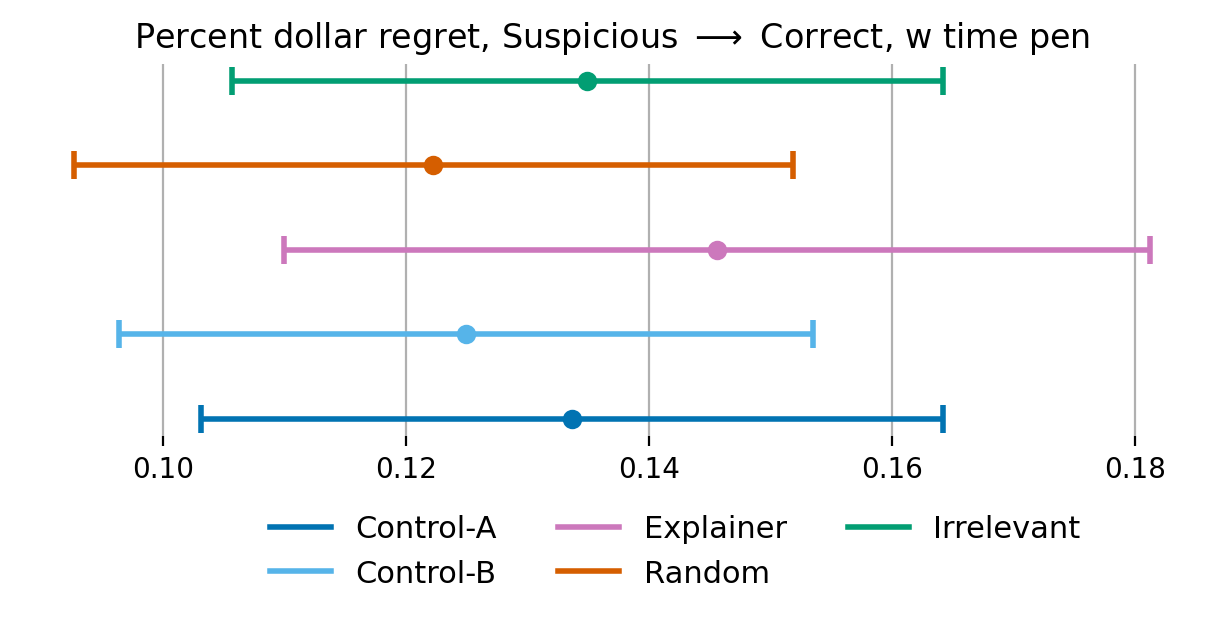

In [34]:
df = pdr(all_decisions, params, 'correct', ['group2'], n_samples=500, n_iterations=100).rename(columns={'group2':'group'})
plot_order = ['Control-A', 'Control-B', 'Explainer', 'Random', 'Irrelevant']
plot_metrics2(
    df, plot_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Correct, w time pen', 
    legend=True,
#     xlim=[0.05, 0.30]
)

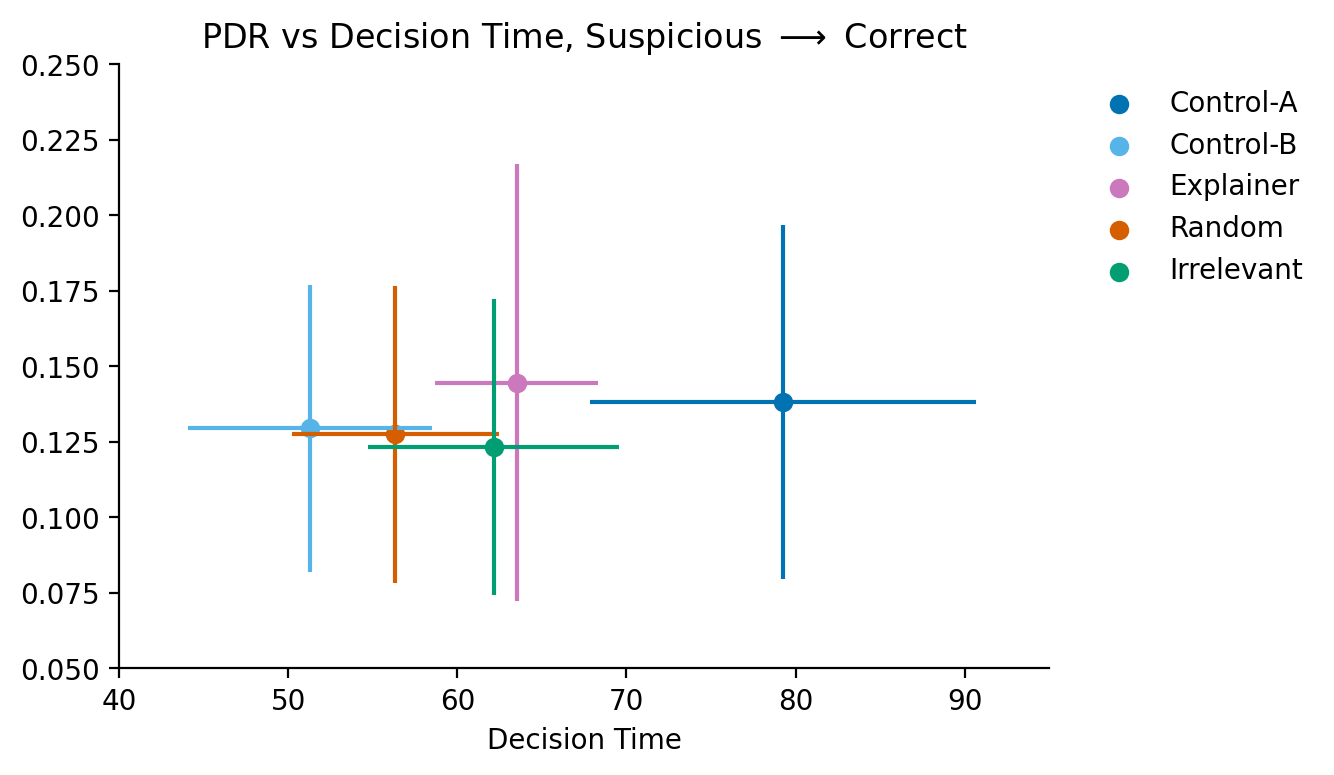

In [102]:
xlim = [40, 95]
ylim = [0.05, 0.25]
regret = pdr(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})
time = dt(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})
plot_time_vs_op_metric(
    regret, time, plot_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

# regret

In [36]:
df

group      mean     n        se       var
0   Control-A  0.133643   495  0.018579  0.170856
1   Control-B  0.124941   499  0.017376  0.150666
2   Explainer  0.145574  1492  0.021662  0.700100
3  Irrelevant  0.134902   499  0.017809  0.158263
4      Random  0.122214   496  0.017991  0.160551

In [38]:
comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'Explainer'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('Random', 'Explainer'),
    ('Irrelevant', 'Explainer'),
    ('Irrelevant', 'Random')
]

In [46]:
params={
    'fn': -3, 
    'p_loss_trx': 0.1, # prob of losing this transaction
    'cust_worth': 5, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

In [47]:
regret = pdr(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})
time = dt(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})
ttests_operational_metrics(regret, comparisons)

{('Control-A', 'Control-B'): {'tstat': 0.07185563506726439,
  'pval': 0.9427312808614315},
 ('Control-B', 'Explainer'): {'tstat': -0.1641069705057976,
  'pval': 0.8696636084622043},
 ('Control-B', 'Random'): {'tstat': 0.24612966161010463,
  'pval': 0.8056327283930891},
 ('Control-B', 'Irrelevant'): {'tstat': 0.008172972089832144,
  'pval': 0.9934806210199313},
 ('Random', 'Explainer'): {'tstat': -0.32137069855340983,
  'pval': 0.747963302616566},
 ('Irrelevant', 'Explainer'): {'tstat': -0.16951156864151323,
  'pval': 0.8654115113196599},
 ('Irrelevant', 'Random'): {'tstat': 0.23340909755373443,
  'pval': 0.8154918554850784}}

In [89]:
comparisons = [
    ('Control-B', 'Explainer'),
    ('Random', 'Explainer'),
    ('Irrelevant', 'Explainer'),
]

param_grid = {
    'fn': [-0.8, -1, -1.2, -2, -3, -5],
    'p_loss_trx': [0.2, 0.3, 0.4], 
    'cust_worth': [0, 1, 3, 5], 
    'p_loss_cust': [0, 0.05, 0.1, 0.3], 
    'p_return_cust': [0, 0.2, 0.3],
    'suspicious_handling': [0, 600, 1800, 3600, 'approve', 'decline'] # If this is an int, it's correct and timepenalty
}

In [94]:
metrics, significance_tests = do_parameter_sweep(all_decisions, ['group2'], comparisons, **param_grid)

metrics.to_csv('param_sweep_op_metrics_combined_explainers.csv', index=False)
significance_tests.to_csv('param_sweep_significance_combined_explainers.csv', index=False)

#### Decision Rates

We are comparing the statistical significance between the difference decision rates. 

In [18]:
grp_object = all_decisions.groupby('group')

In [23]:
contingency_tables = dict()
decisions = list(all_decisions['decision'].unique())

for d in decisions:
    contingency = dict()
    for group, df in grp_object:
        msk = df['decision'] == d
        
        # Number of records belonging to the decision, not belonging to the decision
        contingency[group] = [len(df[msk]), len(df[~msk])]
             
    contingency_tables[d] = contingency

In [30]:
comparisons = [
    ('Data', 'ML Model'),
    ('ML Model', 'LIME'),
    ('ML Model', 'TreeInt'),
    ('ML Model', 'TreeSHAP'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
]

In [37]:
res = list()

for dec in decisions:
    con = contingency_tables[dec]
    for comp in comparisons:
        con_table = [con[comp[0]], con[comp[1]]]
        
        stat, p_val = chi_square_test(np.array(con_table))
        d = dict()
        d['decision'] = dec
        d['comparison'] = comp
        d['p-val'] = p_val
        
        res.append(d)
    

df = pd.DataFrame(res)    

##### Approval

In [39]:
msk = (df['decision'] == 'approved') & (df['p-val'] < 0.1)
df[msk]

comparison  decision     p-val
0        (Data, ML Model)  approved  0.000806
1        (ML Model, LIME)  approved  0.063960
4      (ML Model, Random)  approved  0.046793
5  (ML Model, Irrelevant)  approved  0.034002
9   (Irrelevant, TreeInt)  approved  0.078525

##### Declined/

In [40]:
msk = (df['decision'] == 'declined') & (df['p-val'] < 0.1)
df[msk]

comparison  decision     p-val
16        (Data, ML Model)  declined  0.032712
17        (ML Model, LIME)  declined  0.031578
21  (ML Model, Irrelevant)  declined  0.050053

#### Suspicious

In [42]:
msk = (df['decision'] == 'suspicious') & (df['p-val'] < 0.1)
df[msk]

comparison    decision     p-val
32        (Data, ML Model)  suspicious  0.003378
38       (Random, TreeInt)  suspicious  0.070737
39      (Random, TreeSHAP)  suspicious  0.031457
42  (Irrelevant, TreeSHAP)  suspicious  0.096314

#### Testing error propagation

In [63]:
def pdr_propagated_error(decisions, params, agg_levels=['group']):
    dcs = _modify_value_and_time(all_decisions, params, 'correct')

    dcs['potential_revenue'] = dcs.apply(
        lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
        axis=1
    )
    
    grpobj = dcs.groupby(agg_levels)
    met = list()

    for g, df in grpobj:
        mean_d = df['decision_value'].mean()
        mean_r = df['potential_revenue'].mean()

        var_d = df['decision_value'].var()
        var_r = df['potential_revenue'].var()


        metric = 1 - (mean_d / mean_r) 

        t = np.cov(df['decision_value'], df['potential_revenue']) 
        cov = abs(t[0, 1])

#         metric = 1 - ((mean_d / mean_r) - (cov/mean_r**2) + (var_r * mean_d / mean_r ** 3))

        var = ((1 / mean_r**2) * var_d) + ((mean_d**2 / mean_r**4) * var_r) - (2 * (mean_d / mean_r ** 3) * cov)

        var = abs(var)
        # standard error of the ratio
        se = np.sqrt(var/len(df))

        d = dict()
        
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]

#         d['group'] = g
        d['mean'] = metric
        d['var'] = var
        d['se'] = se
        d['n'] = len(df)

        met.append(d)
        
    return pd.DataFrame(met)

In [64]:
pdr_propagated_error(
    all_decisions, params, ['group']
)

group      mean    n        se       var
0        Data  0.094773  495  0.013707  0.093007
1  Irrelevant  0.096020  499  0.013774  0.094670
2        LIME  0.115255  499  0.018759  0.175593
3    ML Model  0.088291  499  0.011995  0.071801
4      Random  0.089727  496  0.013840  0.095001
5     TreeInt  0.100919  496  0.014170  0.099598
6    TreeSHAP  0.096448  497  0.014622  0.106263

In [42]:
pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)

group      mean    n        se       var
0        Data  0.094754  495  0.013963  0.096508
1  Irrelevant  0.096098  499  0.013890  0.096272
2        LIME  0.116410  499  0.018640  0.173374
3    ML Model  0.088357  499  0.012054  0.072503
4      Random  0.090279  496  0.013313  0.087914
5     TreeInt  0.100740  496  0.013535  0.090860
6    TreeSHAP  0.096257  497  0.014331  0.102075

#### Power

In [77]:
from statsmodels.stats.power import tt_ind_solve_power

In [144]:
def _effect_size_diff(m1, m2, var1, var2):
    sd_pooled = np.sqrt((var1 + var2)/2)

    return (m2 - m1) / sd_pooled

def plot_power_curves(metrics, pvals, sample_sizes_list, group_col='group', save_target=None):
    fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

    for i, row in pvals.iterrows():
        msk = metrics[group_col] == row['comparison'][0]
        m1 = metrics[msk]['mean'].iloc[0]
        v1 = metrics[msk]['var'].iloc[0] 
        n1 = metrics[msk]['n'].iloc[0]
        
        msk = metrics[group_col] == row['comparison'][1]
        m2 = metrics[msk]['mean'].iloc[0]
        v2 = metrics[msk]['var'].iloc[0] 
        n2 = metrics[msk]['n'].iloc[0] 
        
        es = _effect_size_diff(
            m1,
            m2,
            v1,
            v2
        )

        powers = list()
        
        for sample_size in sample_sizes_list:
            power = tt_ind_solve_power(effect_size=es, nobs1=n2, alpha=0.1, ratio=(sample_size/n2), power=None)
            powers.append(power)

        sns.lineplot(sample_sizes_list, powers, label=' vs. '.join(row['comparison'])
#                      , marker='o'
                    )

    plt.axvline(x=500, color='k', linestyle=':', alpha=0.5)
    plt.legend(bbox_to_anchor=(1, 1), frameon=False)
    ax.set_ylabel('statistical power')
    ax.set_xlabel('sample size')

    sns.despine()
    
    if save_target is not None:
        
        plt.savefig(
            save_target, format='pdf', bbox_inches='tight'
        )

    return ax, fig

In [67]:
comparisons = [
    ('Data', 'ML Model'),
    ('ML Model', 'LIME'),
    ('ML Model', 'TreeInt'),
    ('ML Model', 'TreeSHAP'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'TreeInt'),
    ('Random', 'TreeSHAP'),
    ('Random', 'LIME'),
    ('Irrelevant', 'TreeInt'),
    ('Irrelevant', 'TreeSHAP'),
    ('Irrelevant', 'LIME'),
    ('Irrelevant', 'Random'),
    ('LIME', 'TreeSHAP'),
    ('LIME', 'TreeInt'),
    ('TreeSHAP', 'TreeInt')
    
]

In [71]:
met = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)
pvals = ttests_operational_metrics(met, comparisons)

In [104]:
# plot_power_curves(met, pvals, [100, 200, 300, 400, 500, 600, 700])

#### Decision Times

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa03cd60d68>,
 <Figure size 1000x800 with 1 Axes>)

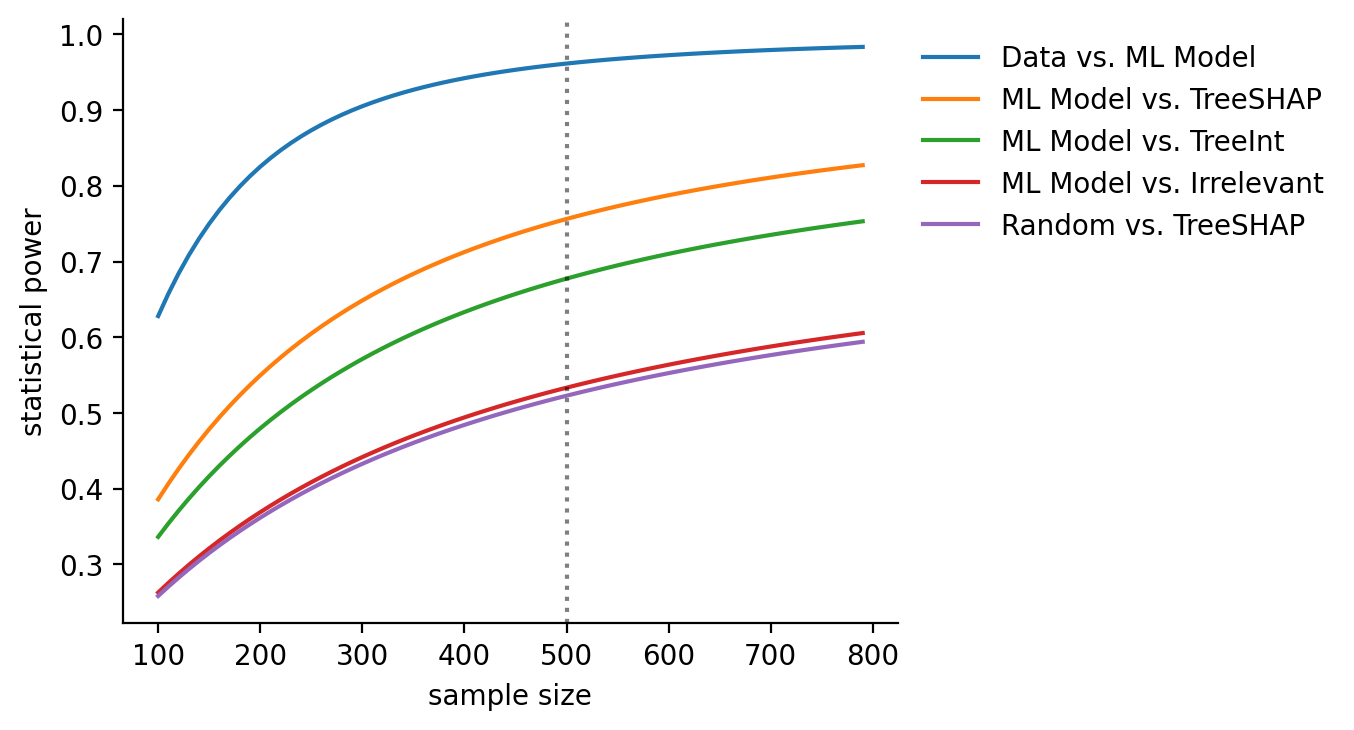

In [145]:
dec_time = dt(all_decisions, params, 'correct', ['group'])
pvals = ttests_operational_metrics(dec_time, comparisons)

msk = pvals['p-val'] < 0.1
plot_power_curves(dec_time, pvals[msk].sort_values('p-val'), list(np.arange(100, 800, 10)), 
#                   save_target='results/figures_for_paper/power_time.pdf'
                 )

In [106]:
def group_explainers(row):
    if row['group'] in {'LIME', 'TreeSHAP', 'TreeInt'}:
        return 'Explainer'
    else:
        return row['group']
    
    
all_decisions['group2'] = all_decisions.apply(lambda x: group_explainers(x), axis=1)

In [108]:
comparisons2 = [
    ('Data', 'ML Model'),
    ('ML Model', 'Explainer'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'Explainer'),
    ('Irrelevant', 'Explainer'),
    ('Irrelevant', 'Random')    
]

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa03d774860>,
 <Figure size 900x600 with 1 Axes>)

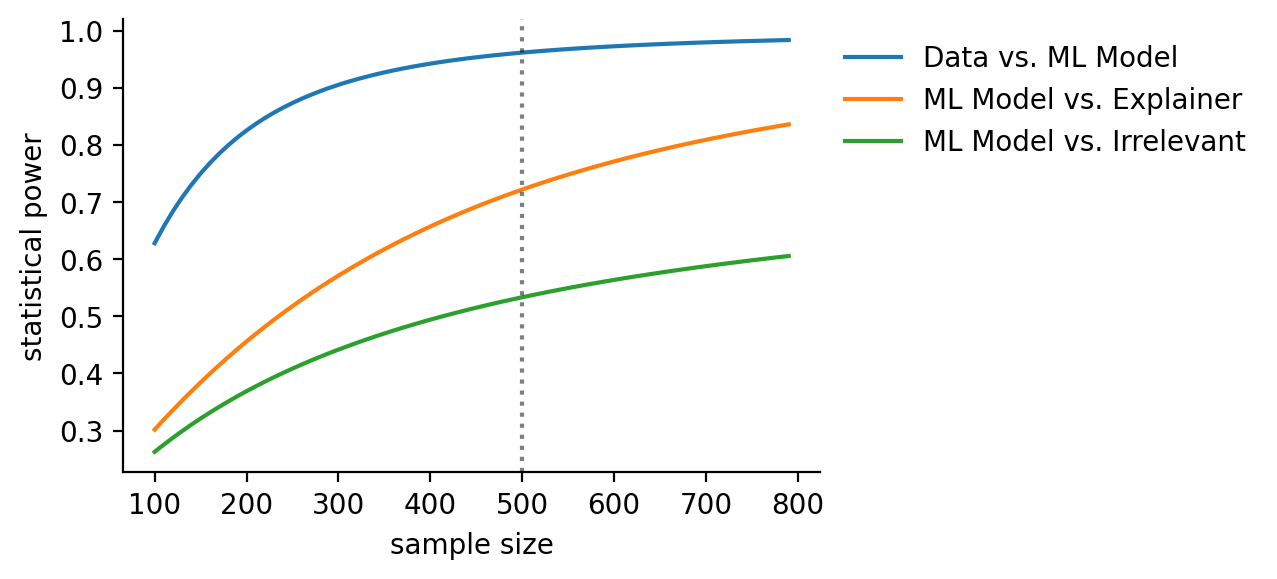

In [139]:
dec_time = dt(all_decisions, params, 'correct', ['group2'])
pvals = ttests_operational_metrics(dec_time, comparisons2, group_col='group2')

msk = pvals['p-val'] < 0.1
plot_power_curves(dec_time, pvals[msk].sort_values('p-val'), list(np.arange(100, 800, 10)), group_col='group2', 
                  save_target='results/figures_for_paper/power_time_combined_explainer.pdf'
                 )